In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.optimize import curve_fit
import os

%matplotlib inline

In [2]:
signal_dir = "/scratch/elena/waveform_npz/run2521/"
control_dir = "/scratch/elena/waveform_npz/run2519/"

signal_files = [f for f in os.listdir(signal_dir) if f.endswith(".npz")]
control_files = [f for f in os.listdir(control_dir) if f.endswith(".npz")]

signal_pmts = set(f.replace(".npz", "") for f in signal_files)
control_pmts = set(f.replace(".npz", "") for f in control_files)

pmts_both = sorted(list(signal_pmts & control_pmts))

print(f"Number of PMTs in both files: {len(pmts_both)}")
print("Some examples:", pmts_both[:20])

Number of PMTs in both files: 1548
Some examples: ['card100_slot24_ch0', 'card100_slot24_ch1', 'card100_slot24_ch10', 'card100_slot24_ch11', 'card100_slot24_ch12', 'card100_slot24_ch13', 'card100_slot24_ch14', 'card100_slot24_ch15', 'card100_slot24_ch16', 'card100_slot24_ch17', 'card100_slot24_ch18', 'card100_slot24_ch2', 'card100_slot24_ch3', 'card100_slot24_ch4', 'card100_slot24_ch5', 'card100_slot24_ch6', 'card100_slot24_ch7', 'card100_slot24_ch8', 'card100_slot24_ch9', 'card101_slot20_ch0']


In [3]:
card_id = 100
slot_id = 24
channel_id = 11

pmt_label = f"card{card_id}_slot{slot_id}_ch{channel_id}"

signal_npz = f"/scratch/elena/waveform_npz/run2521/{pmt_label}.npz"    #signal run2521
control_npz = f"/scratch/elena/waveform_npz/run2519/{pmt_label}.npz"   #control run2519

In [4]:
def load_waveforms(npz_file):
    data = np.load(npz_file)
    return data["waveforms"]  # shape: (n_events, n_bins)

signal_waveforms = load_waveforms(signal_npz)
control_waveforms = load_waveforms(control_npz)

print("Loaded signal waveforms:", signal_waveforms.shape)
print("Loaded control waveforms:", control_waveforms.shape)

Loaded signal waveforms: (10000, 64)
Loaded control waveforms: (10000, 64)


In [5]:
def compute_charges(waveforms, integration_range=None):
    """
    Calcula la carga integrada de cada waveform.
    waveforms: (n_events, n_bins)
    integration_range: tuple (lo, hi) en bins. Si None, usa toda la waveform.
    """
    if integration_range is None:
        return waveforms.sum(axis=1)
    lo, hi = integration_range
    return waveforms[:, lo:hi].sum(axis=1)

# --- calcular cargas ---
signal_charges = compute_charges(signal_waveforms)
control_charges = compute_charges(control_waveforms)

print("Signal charges:", signal_charges.shape)
print("Control charges:", control_charges.shape)

# --- plots comparativos ---
plt.figure(figsize=(7,4.5))
bins = np.linspace(
    min(control_charges.min(), signal_charges.min()),
    max(control_charges.max(), signal_charges.max()),
    120
)

Signal charges: (10000,)
Control charges: (10000,)


<Figure size 700x450 with 0 Axes>

Eso que comentas indica que ahora lo que has calculado (signal_charges, control_charges) ya no son waveforms, sino los valores integrados de carga por cada waveform.

Te explico:

Antes (signal_waveforms.shape = (10000, 64)):
→ 10 000 waveforms (triggers) × 64 samples cada una.

Después de aplicar compute_charges(...):
→ signal_charges.shape = (10000,) porque hemos colapsado los 64 samples en un único número (la carga integrada de cada waveform).

Esto es totalmente esperado.
Ya no tenemos la forma temporal de cada pulso, sino un histograma de cargas integradas → eso es justo lo que quieres para ver el pedestal vs s.p.e.

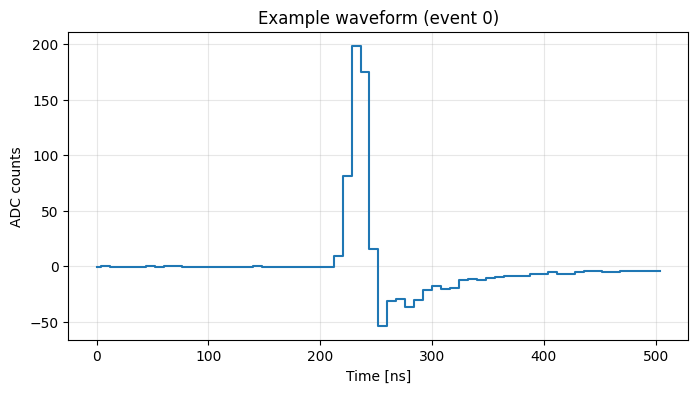

Integrated charge for event 0: 55.40 ADC·counts


In [6]:
# Selecciona un evento cualquiera
i = 0  
wf = signal_waveforms[i]

plt.figure(figsize=(8,4))
plt.plot(np.arange(64)*8, wf, drawstyle="steps-mid")
plt.xlabel("Time [ns]")
plt.ylabel("ADC counts")
plt.title(f"Example waveform (event {i})")
plt.grid(alpha=0.3)
plt.show()

# Calcular la carga de esta waveform
charge = np.sum(wf)
print(f"Integrated charge for event {i}: {charge:.2f} ADC·counts")

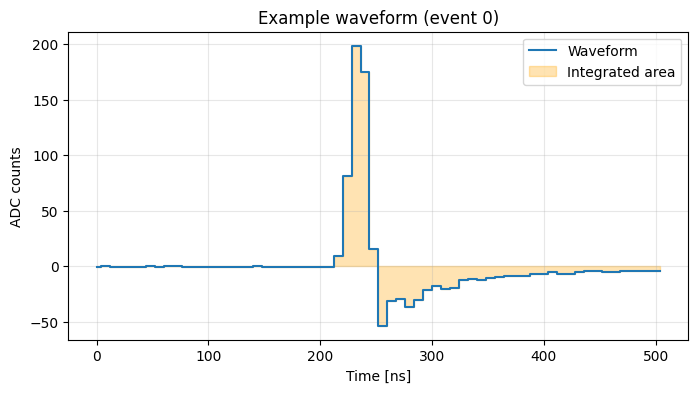

Integrated charge for event 0: 443.20 ADC·ns


In [7]:
# Selecciona un evento cualquiera
i = 0  
wf = signal_waveforms[i]

# Eje de tiempos (64 samples * 8 ns)
time_axis = np.arange(64) * 8  

# Calcular la carga: sumatoria de wf * 8 ns
charge = np.sum(wf) * 8  

plt.figure(figsize=(8,4))
plt.plot(time_axis, wf, drawstyle="steps-mid", label="Waveform")
plt.fill_between(time_axis, wf, step="mid", alpha=0.3, color="orange", label="Integrated area")
plt.xlabel("Time [ns]")
plt.ylabel("ADC counts")
plt.title(f"Example waveform (event {i})")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"Integrated charge for event {i}: {charge:.2f} ADC·ns")   # x8 ns porque cada sample (64 per waveform) es de 8ns

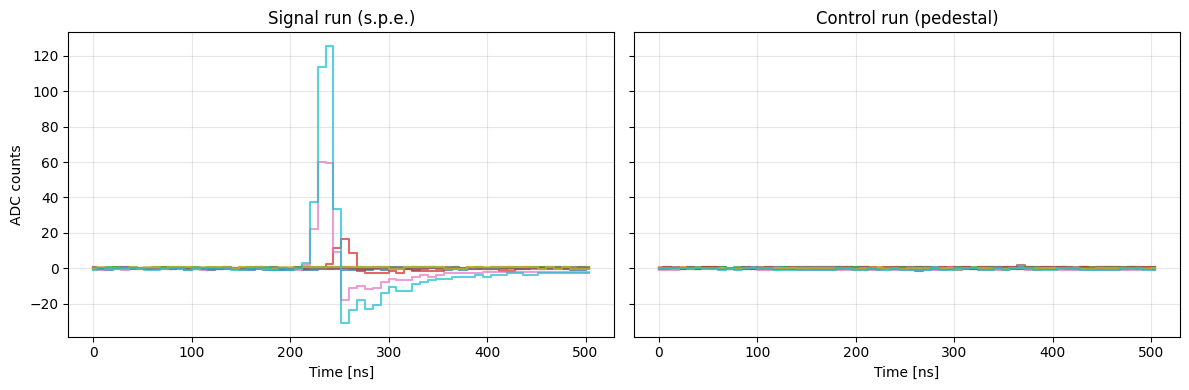

In [8]:
def plot_random_waveforms(signal_waveforms, control_waveforms, n_events=5):
    # elegir índices aleatorios
    sig_idx = np.random.choice(signal_waveforms.shape[0], n_events, replace=False)
    ctrl_idx = np.random.choice(control_waveforms.shape[0], n_events, replace=False)

    time = np.arange(signal_waveforms.shape[1]) * 8  #cada sample = 8 ns

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    # --------singal----------
    for i in sig_idx:
        wf = signal_waveforms[i]
        axes[0].plot(time, wf, drawstyle="steps-mid", alpha=0.7)
    axes[0].set_title("Signal run (s.p.e.)")
    axes[0].set_xlabel("Time [ns]")
    axes[0].set_ylabel("ADC counts")
    axes[0].grid(alpha=0.3)

    # ------control----------
    for i in ctrl_idx:
        wf = control_waveforms[i]
        axes[1].plot(time, wf, drawstyle="steps-mid", alpha=0.7)
    axes[1].set_title("Control run (pedestal)")
    axes[1].set_xlabel("Time [ns]")
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


plot_random_waveforms(signal_waveforms, control_waveforms, n_events=10)

En la señal (LED, s.p.e.) → picos muy claros centrados en cierto rango (~200 ns). Eso son tus pulsos de fotoelectrones.

En el control (pedestal) → solo ruido alrededor de cero (sin pulsos). Eso es lo esperado: el trigger se disparó pero sin LED, por lo que solo mides la base electrónica.

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# --- PMT to test ---
card_id = 100
slot_id = 24
channel_id = 16
pmt_label = f"card{card_id}_slot{slot_id}_ch{channel_id}"

signal_npz  = f"/scratch/elena/waveform_npz/run2521/{pmt_label}.npz"
control_npz = f"/scratch/elena/waveform_npz/run2519/{pmt_label}.npz"

bin_width = 8.0  # ns per bin
threshold = 50

# --- Your original functions ---
def load_waveforms(npz_file):
    data = np.load(npz_file)
    return data["waveforms"]

def integrate_waveform_signal(wf, pre_peak, post_peak):
    peak_idx = np.argmax(wf)
    start = max(0, peak_idx - pre_peak)
    end   = min(len(wf), peak_idx + post_peak + 1)
    return np.sum(wf[start:end])

# --- Load waveforms ---
signal_waveforms = load_waveforms(signal_npz)
control_waveforms = load_waveforms(control_npz)

# --- Pick first valid waveform above threshold ---
valid_indices = [i for i, wf in enumerate(signal_waveforms) if np.max(wf) > threshold]
if len(valid_indices) == 0:
    raise RuntimeError(f"No waveform above threshold {threshold} found for {pmt_label}")

wf_index = valid_indices[0]
wf = signal_waveforms[wf_index]
peak_idx = int(np.argmax(wf))
n_samples = len(wf)
time_axis = np.arange(n_samples) * bin_width

print(f"Using waveform index {wf_index}, peak at bin {peak_idx}")

# --- Windows to test: (pre_peak, post_peak) ---
windows = [(-4,+2), (-5,+2), (-3,+2)]
results = []

for w in windows:
    pre_peak = -w[0]  # number of bins before peak (make positive)
    post_peak = w[1]  # number of bins after peak
    Q = integrate_waveform_signal(wf, pre_peak, post_peak) * bin_width
    start = max(0, peak_idx - pre_peak)
    end   = min(n_samples, peak_idx + post_peak + 1)
    n_bins = end - start
    results.append({'window': w, 'start': start, 'end': end, 'n_bins': n_bins, 'Q': Q})

# --- Print table ---
print("\nResults per window:")
print(f"{'window':12s} {'start':>5s} {'end':>5s} {'bins':>5s} {'Q [ADC·ns]':>12s}")
for r in results:
    wstr = f"[{r['window'][0]},{r['window'][1]}]"
    print(f"{wstr:12s} {r['start']:5d} {r['end']:5d} {r['n_bins']:5d} {r['Q']:12.1f}")

Using waveform index 16, peak at bin 30

Results per window:
window       start   end  bins   Q [ADC·ns]
[-4,2]          26    33     7       1507.2
[-5,2]          25    33     8       1508.8
[-3,2]          27    33     6       1505.6


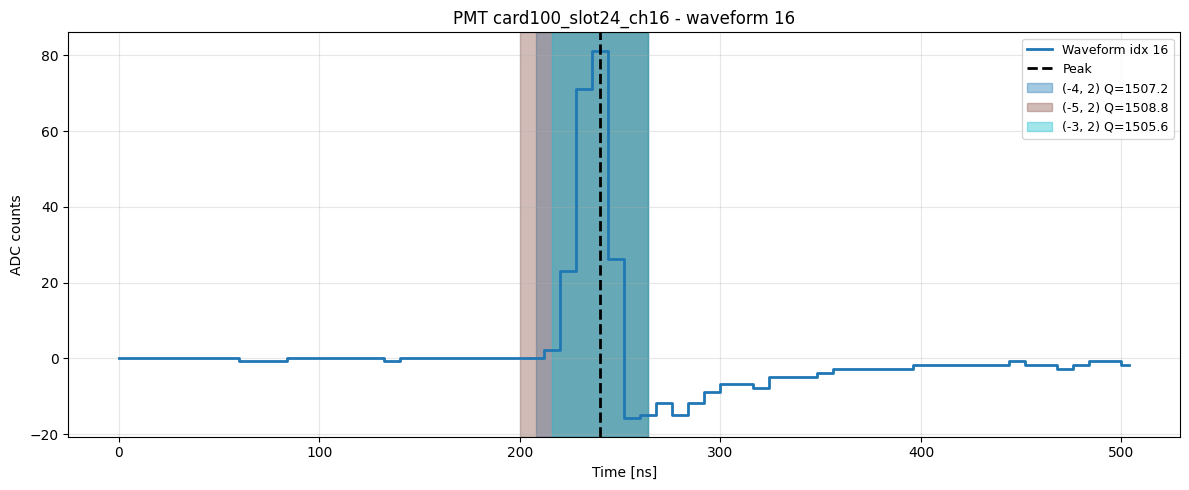

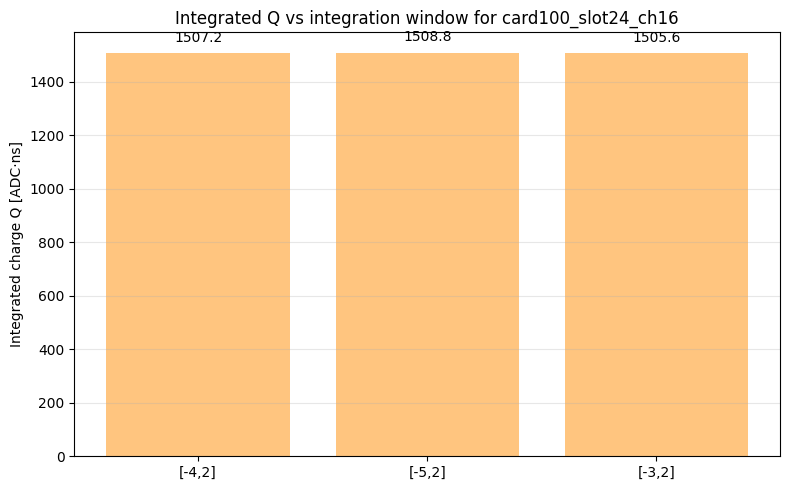

In [10]:
# --- Plot waveform with shaded windows ---
plt.figure(figsize=(12,5))
plt.plot(time_axis, wf, drawstyle="steps-mid", lw=2, label=f"Waveform idx {wf_index}")
plt.axvline(peak_idx*bin_width, color='k', ls='--', lw=2, label='Peak')

colors = plt.cm.tab10(np.linspace(0,1,len(windows)))
for r, c in zip(results, colors):
    xs = time_axis[r['start']]
    xe = time_axis[r['end']-1] + bin_width
    plt.axvspan(xs, xe, alpha=0.4, color=c, label=f"{r['window']} Q={r['Q']:.1f}")

plt.xlabel("Time [ns]")
plt.ylabel("ADC counts")
plt.title(f"PMT {pmt_label} - waveform {wf_index}")
plt.legend(fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- Bar plot Q vs window ---
plt.figure(figsize=(8,5))
labels = [f"[{w[0]},{w[1]}]" for w in windows]
Qs = [r['Q'] for r in results]

bars = plt.bar(labels, Qs, alpha=0.5, color='darkorange')

# Añadir los valores de Q encima de cada barra
for bar, Q in zip(bars, Qs):
    plt.text(bar.get_x() + bar.get_width()/2, Q + 0.02*max(Qs), f"{Q:.1f}", 
             ha='center', va='bottom', fontsize=10)

plt.ylabel("Integrated charge Q [ADC·ns]")
plt.title(f"Integrated Q vs integration window for {pmt_label}")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


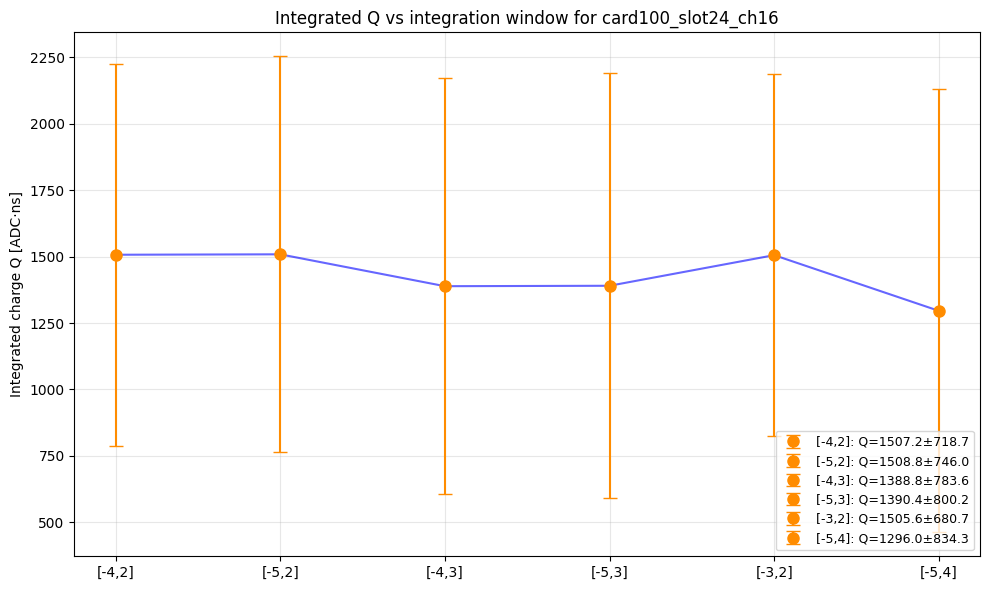

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# --- PMT and waveform setup ---
card_id = 100
slot_id = 24
channel_id = 16
pmt_label = f"card{card_id}_slot{slot_id}_ch{channel_id}"

signal_npz = f"/scratch/elena/waveform_npz/run2521/{pmt_label}.npz"
bin_width = 8.0  # ns per bin
threshold = 50

def load_waveforms(npz_file):
    data = np.load(npz_file)
    return data["waveforms"]

def integrate_waveform_signal(wf, pre_peak, post_peak):
    peak_idx = np.argmax(wf)
    start = max(0, peak_idx - pre_peak)
    end   = min(len(wf), peak_idx + post_peak + 1)
    return np.sum(wf[start:end]), start, end

signal_waveforms = load_waveforms(signal_npz)

# --- Pick first valid waveform ---
valid_indices = [i for i, wf in enumerate(signal_waveforms) if np.max(wf) > threshold]
wf_index = valid_indices[0]
wf = signal_waveforms[wf_index]
peak_idx = int(np.argmax(wf))

# --- Windows to test ---
windows = [(-4,+2), (-5,+2), (-4,+3), (-5,+3), (-3,+2), (-5,+4)]
window_labels = [f"[{w[0]},{w[1]}]" for w in windows]
Qs = []
Qerrs = []

for w in windows:
    pre_peak = -w[0]
    post_peak = w[1]
    Q, start, end = integrate_waveform_signal(wf, pre_peak, post_peak)
    Q *= bin_width
    sigma_Q = np.std(wf[start:end]) * np.sqrt(end-start) * bin_width
    Qs.append(Q)
    Qerrs.append(sigma_Q)

# --- Scatter plot with legend showing Q ± σ_Q ---
plt.figure(figsize=(10,6))
x = np.arange(len(windows))

for xi, Q, err, label in zip(x, Qs, Qerrs, window_labels):
    plt.errorbar(xi, Q, yerr=err, fmt='o', markersize=8, capsize=5, color='darkorange',
                 label=f"{label}: Q={Q:.1f}±{err:.1f}")
    
plt.plot(x, Qs, '-o', color='blue', alpha=0.6)  # line connecting points

plt.xticks(x, window_labels)
plt.ylabel("Integrated charge Q [ADC·ns]")
plt.title(f"Integrated Q vs integration window for {pmt_label}")
plt.grid(alpha=0.3)
plt.legend(fontsize=9, loc='lower right')
plt.tight_layout()
plt.show()


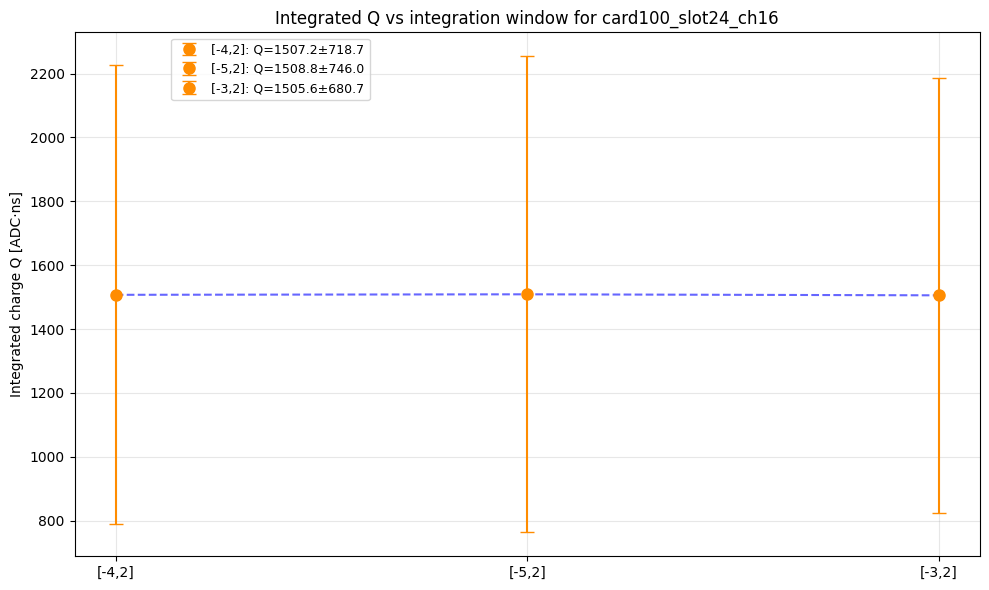

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# --- PMT and waveform setup ---
card_id = 100
slot_id = 24
channel_id = 16
pmt_label = f"card{card_id}_slot{slot_id}_ch{channel_id}"

signal_npz = f"/scratch/elena/waveform_npz/run2521/{pmt_label}.npz"
bin_width = 8.0  # ns per bin
threshold = 50

def load_waveforms(npz_file):
    data = np.load(npz_file)
    return data["waveforms"]

def integrate_waveform_signal(wf, pre_peak, post_peak):
    peak_idx = np.argmax(wf)
    start = max(0, peak_idx - pre_peak)
    end   = min(len(wf), peak_idx + post_peak + 1)
    return np.sum(wf[start:end]), start, end

signal_waveforms = load_waveforms(signal_npz)

# --- Pick first valid waveform ---
valid_indices = [i for i, wf in enumerate(signal_waveforms) if np.max(wf) > threshold]
wf_index = valid_indices[0]
wf = signal_waveforms[wf_index]
peak_idx = int(np.argmax(wf))

# --- Windows to test ---
windows = [(-4,+2), (-5,+2), (-3,+2)]
window_labels = [f"[{w[0]},{w[1]}]" for w in windows]
Qs = []
Qerrs = []

for w in windows:
    pre_peak = -w[0]
    post_peak = w[1]
    Q, start, end = integrate_waveform_signal(wf, pre_peak, post_peak)
    Q *= bin_width
    sigma_Q = np.std(wf[start:end]) * np.sqrt(end-start) * bin_width
    Qs.append(Q)
    Qerrs.append(sigma_Q)

# --- Scatter plot with legend showing Q ± σ_Q ---
plt.figure(figsize=(10,6))
x = np.arange(len(windows))

for xi, Q, err, label in zip(x, Qs, Qerrs, window_labels):
    plt.errorbar(xi, Q, yerr=err, fmt='o', markersize=8, capsize=5, color='darkorange',
                 label=f"{label}: Q={Q:.1f}±{err:.1f}")
    
plt.plot(x, Qs, '--', color='blue', alpha=0.6)  # line connecting points

plt.xticks(x, window_labels)
plt.ylabel("Integrated charge Q [ADC·ns]")
plt.title(f"Integrated Q vs integration window for {pmt_label}")
plt.grid(alpha=0.3)
plt.legend(fontsize=9, bbox_to_anchor=(0.1, 1))
plt.tight_layout()
plt.show()


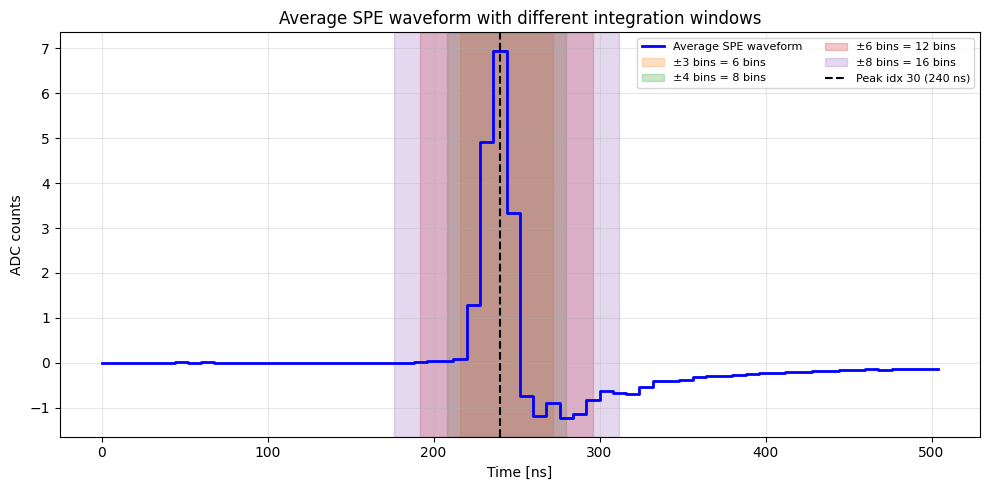

In [13]:
bin_width = 8.0  # ns per sample
time_axis = np.arange(signal_waveforms.shape[1]) * bin_width

# --- compute average SPE waveform (template) ---
avg_wf = np.mean(signal_waveforms, axis=0)
peak_idx = int(np.argmax(avg_wf))

# define integration half-widths (±N bins around peak)
half_windows = [3, 4, 6, 8]   # total bins = 2N
colors = ['tab:orange', 'tab:green', 'tab:red', 'tab:purple']

plt.figure(figsize=(10, 5))
plt.plot(time_axis, avg_wf, drawstyle="steps-mid", color="blue", lw=2, label="Average SPE waveform")

# draw integration windows in different colors
for N, col in zip(half_windows, colors):
    start = max(0, peak_idx - N)
    end = min(len(avg_wf), peak_idx + N + 1)
    plt.axvspan(time_axis[start], time_axis[end-1] + bin_width,
                alpha=0.25, color=col,
                label=f'±{N} bins = {2*N} bins')

# mark the peak
plt.axvline(peak_idx*bin_width, color='k', linestyle='--', label=f'Peak idx {peak_idx} ({peak_idx*bin_width:.0f} ns)')

plt.xlabel("Time [ns]")
plt.ylabel("ADC counts")
plt.title("Average SPE waveform with different integration windows")
plt.legend(loc="upper right", fontsize=8, ncol=2)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
card_id = 34
slot_id = 78
channel_id = 13

pmt_label = f"card{card_id}_slot{slot_id}_ch{channel_id}"

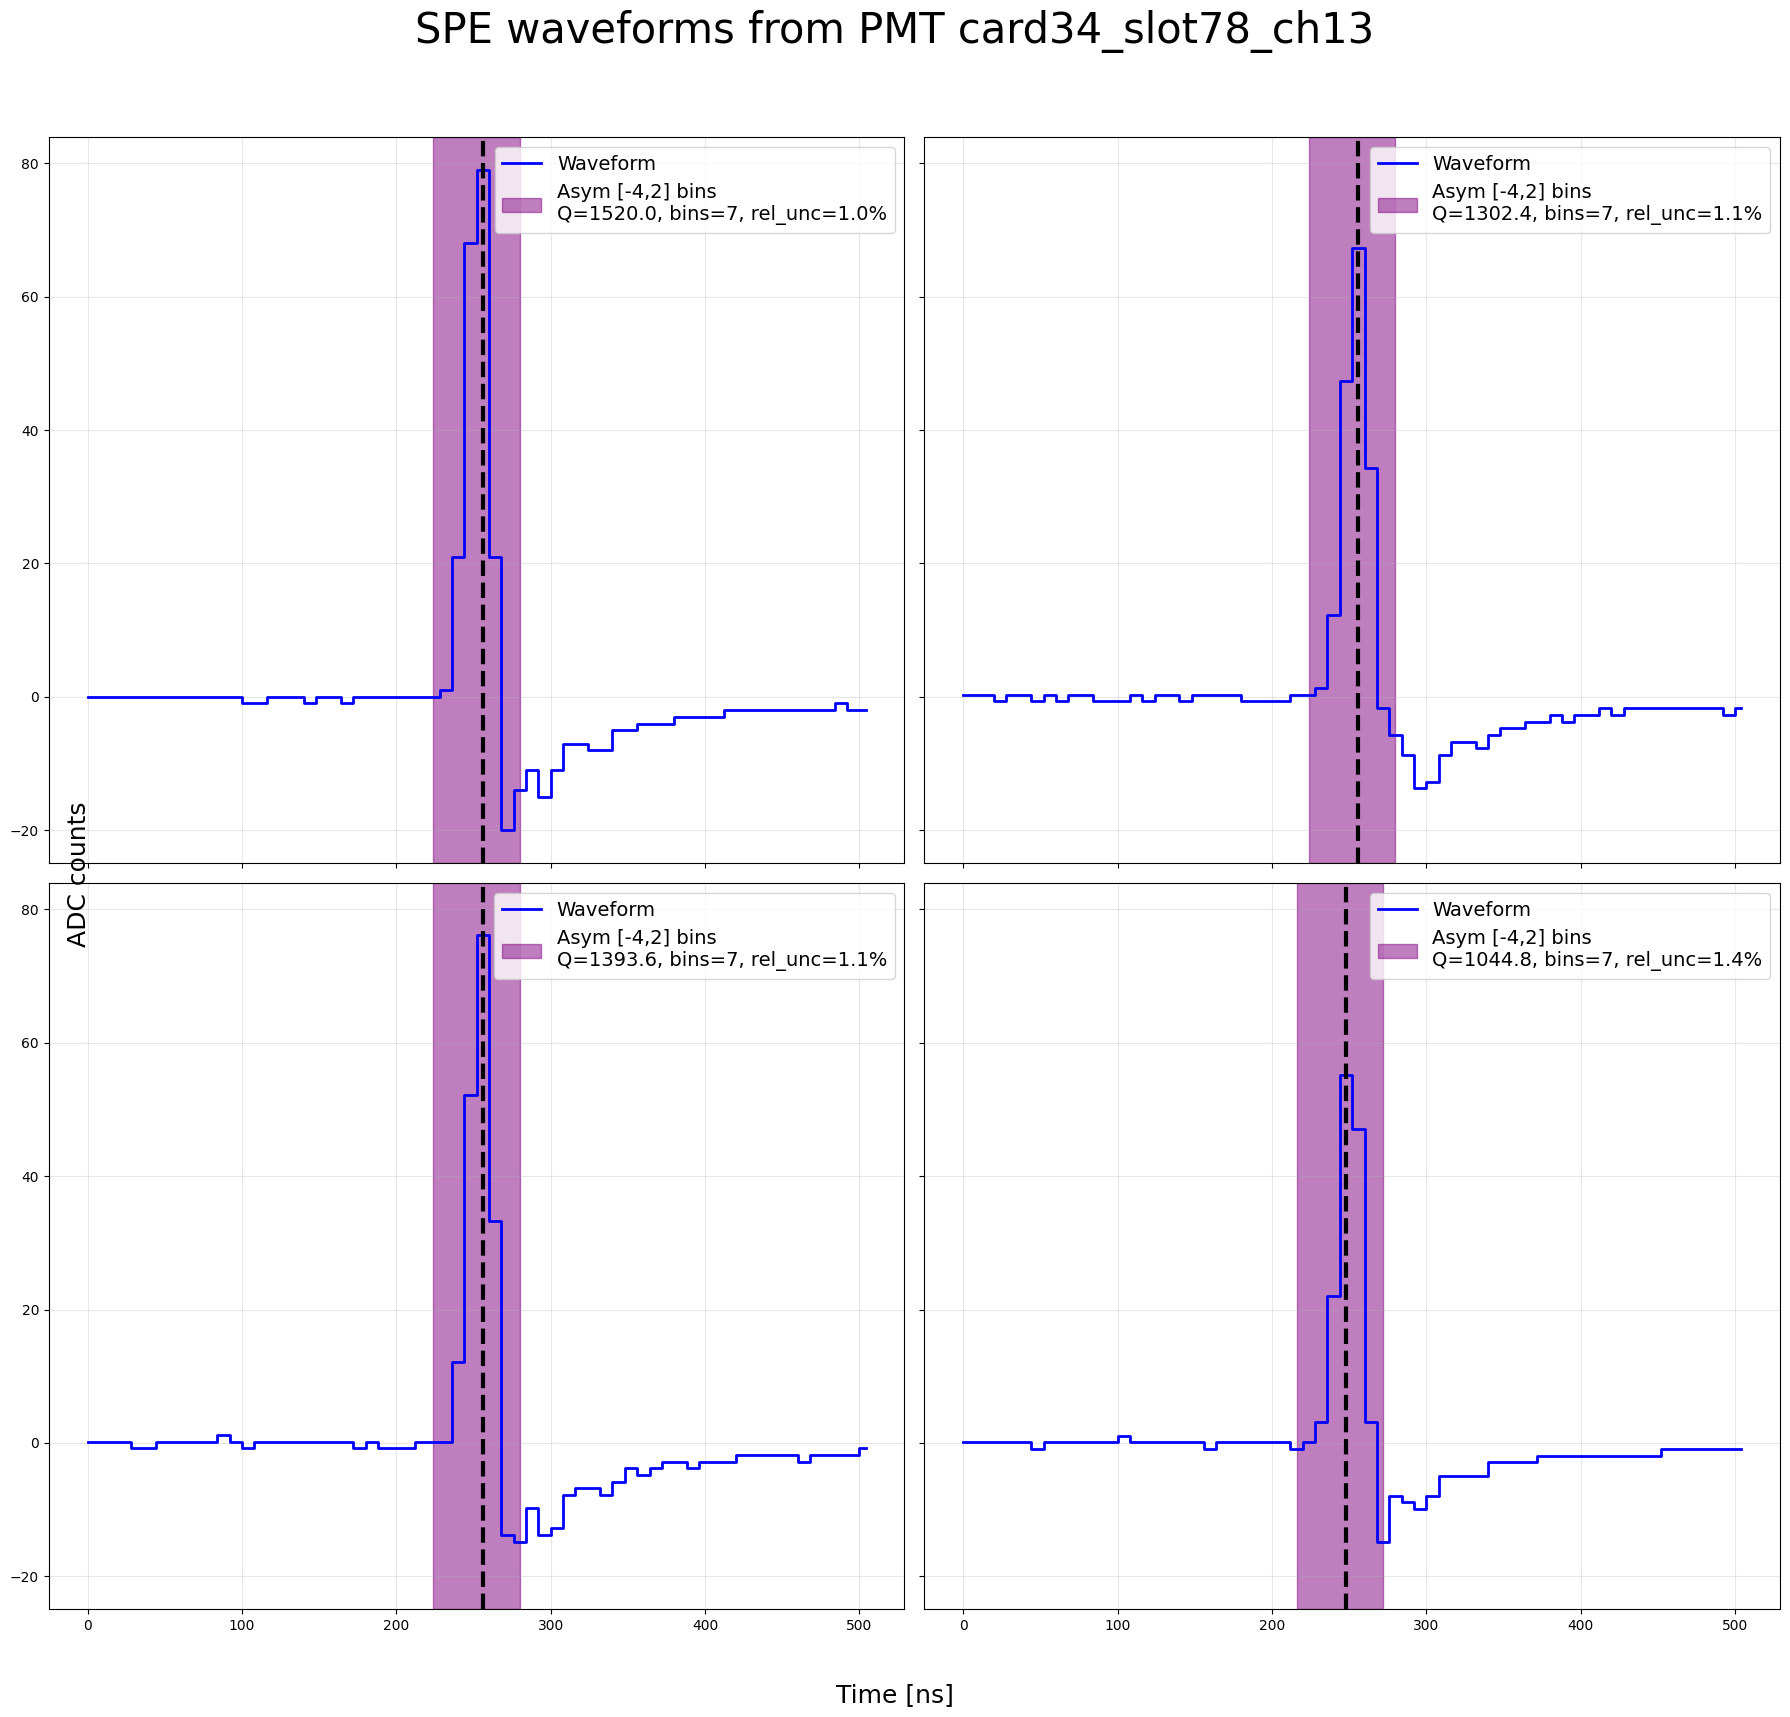

In [15]:

bin_width = 8.0  # 8 ns per sample/bin

# Load waveforms
signal_data = np.load(f"/scratch/elena/waveform_npz/run2521/{pmt_label}.npz")
control_data = np.load(f"/scratch/elena/waveform_npz/run2519/{pmt_label}.npz")

signal_waveforms = signal_data["waveforms"]
control_waveforms = control_data["waveforms"]

time_axis = np.arange(signal_waveforms.shape[1]) * bin_width

asym_window = (-4, +2)   
#asym_window_2 = (-3, +2)    

# Noise estimation (from pedestal run or RMS of baseline in signal run)
sigma_sample = np.std(control_waveforms[:, :20])  # adjust baseline region if needed

n_rows, n_cols = 2,2
n_waveforms = n_rows * n_cols
threshold = 50  # ADC counts

valid_indices = [i for i, wf in enumerate(signal_waveforms) if np.max(wf) > threshold]

#chose random waveforms!
indices = np.random.choice(valid_indices, n_waveforms, replace=False)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 18), sharex=True, sharey=True)

for ax, idx in zip(axes.flat, indices):
    wf = signal_waveforms[idx]
    peak_idx = int(np.argmax(wf))
    
    # Asymmetric window
    start_asym = max(0, peak_idx + asym_window[0])
    end_asym   = min(len(wf), peak_idx + asym_window[1] + 1)
    bins_asym = end_asym - start_asym
    Q_asym = np.sum(np.clip(wf[start_asym:end_asym], 0, None)) * bin_width
    sigma_Q_asym = np.sqrt(bins_asym) * sigma_sample * bin_width
    rel_unc_asym = sigma_Q_asym / Q_asym * 100 if Q_asym > 0 else np.nan
    
    # Asymmetric window 2 (optional)
    #start_asym_2 = max(0, peak_idx + asym_window_2[0])
    #end_asym_2   = min(len(wf), peak_idx + asym_window_2[1] + 1)
    #bins_asym_2 = end_asym_2 - start_asym_2
    #Q_asym_2 = np.sum(np.clip(wf[start_asym_2:end_asym_2], 0, None)) * bin_width
    #sigma_Q_asym_2 = np.sqrt(bins_asym_2) * sigma_sample * bin_width
    #rel_unc_asym_2 = sigma_Q_asym_2 / Q_asym_2 * 100 if Q_asym_2 > 0 else np.nan
    
    ax.plot(time_axis, wf, drawstyle="steps-mid", lw=2, color="blue", label="Waveform")
    ax.axvline(peak_idx * bin_width, color="k", linestyle="--", lw=3)
   
    ax.axvspan(time_axis[start_asym], time_axis[end_asym-1] + bin_width,
               alpha=0.5, color="purple", label=(
                   f"Asym [{asym_window[0]},{asym_window[1]}] bins\n"
                   f"Q={Q_asym:.1f}, bins={bins_asym}, rel_unc={rel_unc_asym:.1f}%"))
    
    #ax.axvspan(time_axis[start_asym_2], time_axis[end_asym_2-1] + bin_width,
    #           alpha=0.6, color="orange", label=(
    #               f"Asym_2 [{asym_window_2[0]},{asym_window_2[1]}] bins\n"
    #               f"Q={Q_asym_2:.1f}, bins={bins_asym_2}, rel_unc={rel_unc_asym_2:.1f}%"))
    
    ax.legend(fontsize=14, loc="upper right")
    ax.grid(alpha=0.3)

fig.text(0.5, 0.04, "Time [ns]", ha="center", fontsize=18)
fig.text(0.04, 0.5, "ADC counts", va="center", rotation="vertical", fontsize=18)
fig.suptitle(f"SPE waveforms from PMT {pmt_label}", fontsize=30)
plt.tight_layout(rect=[0, 0.07, 1, 0.95])
plt.show()

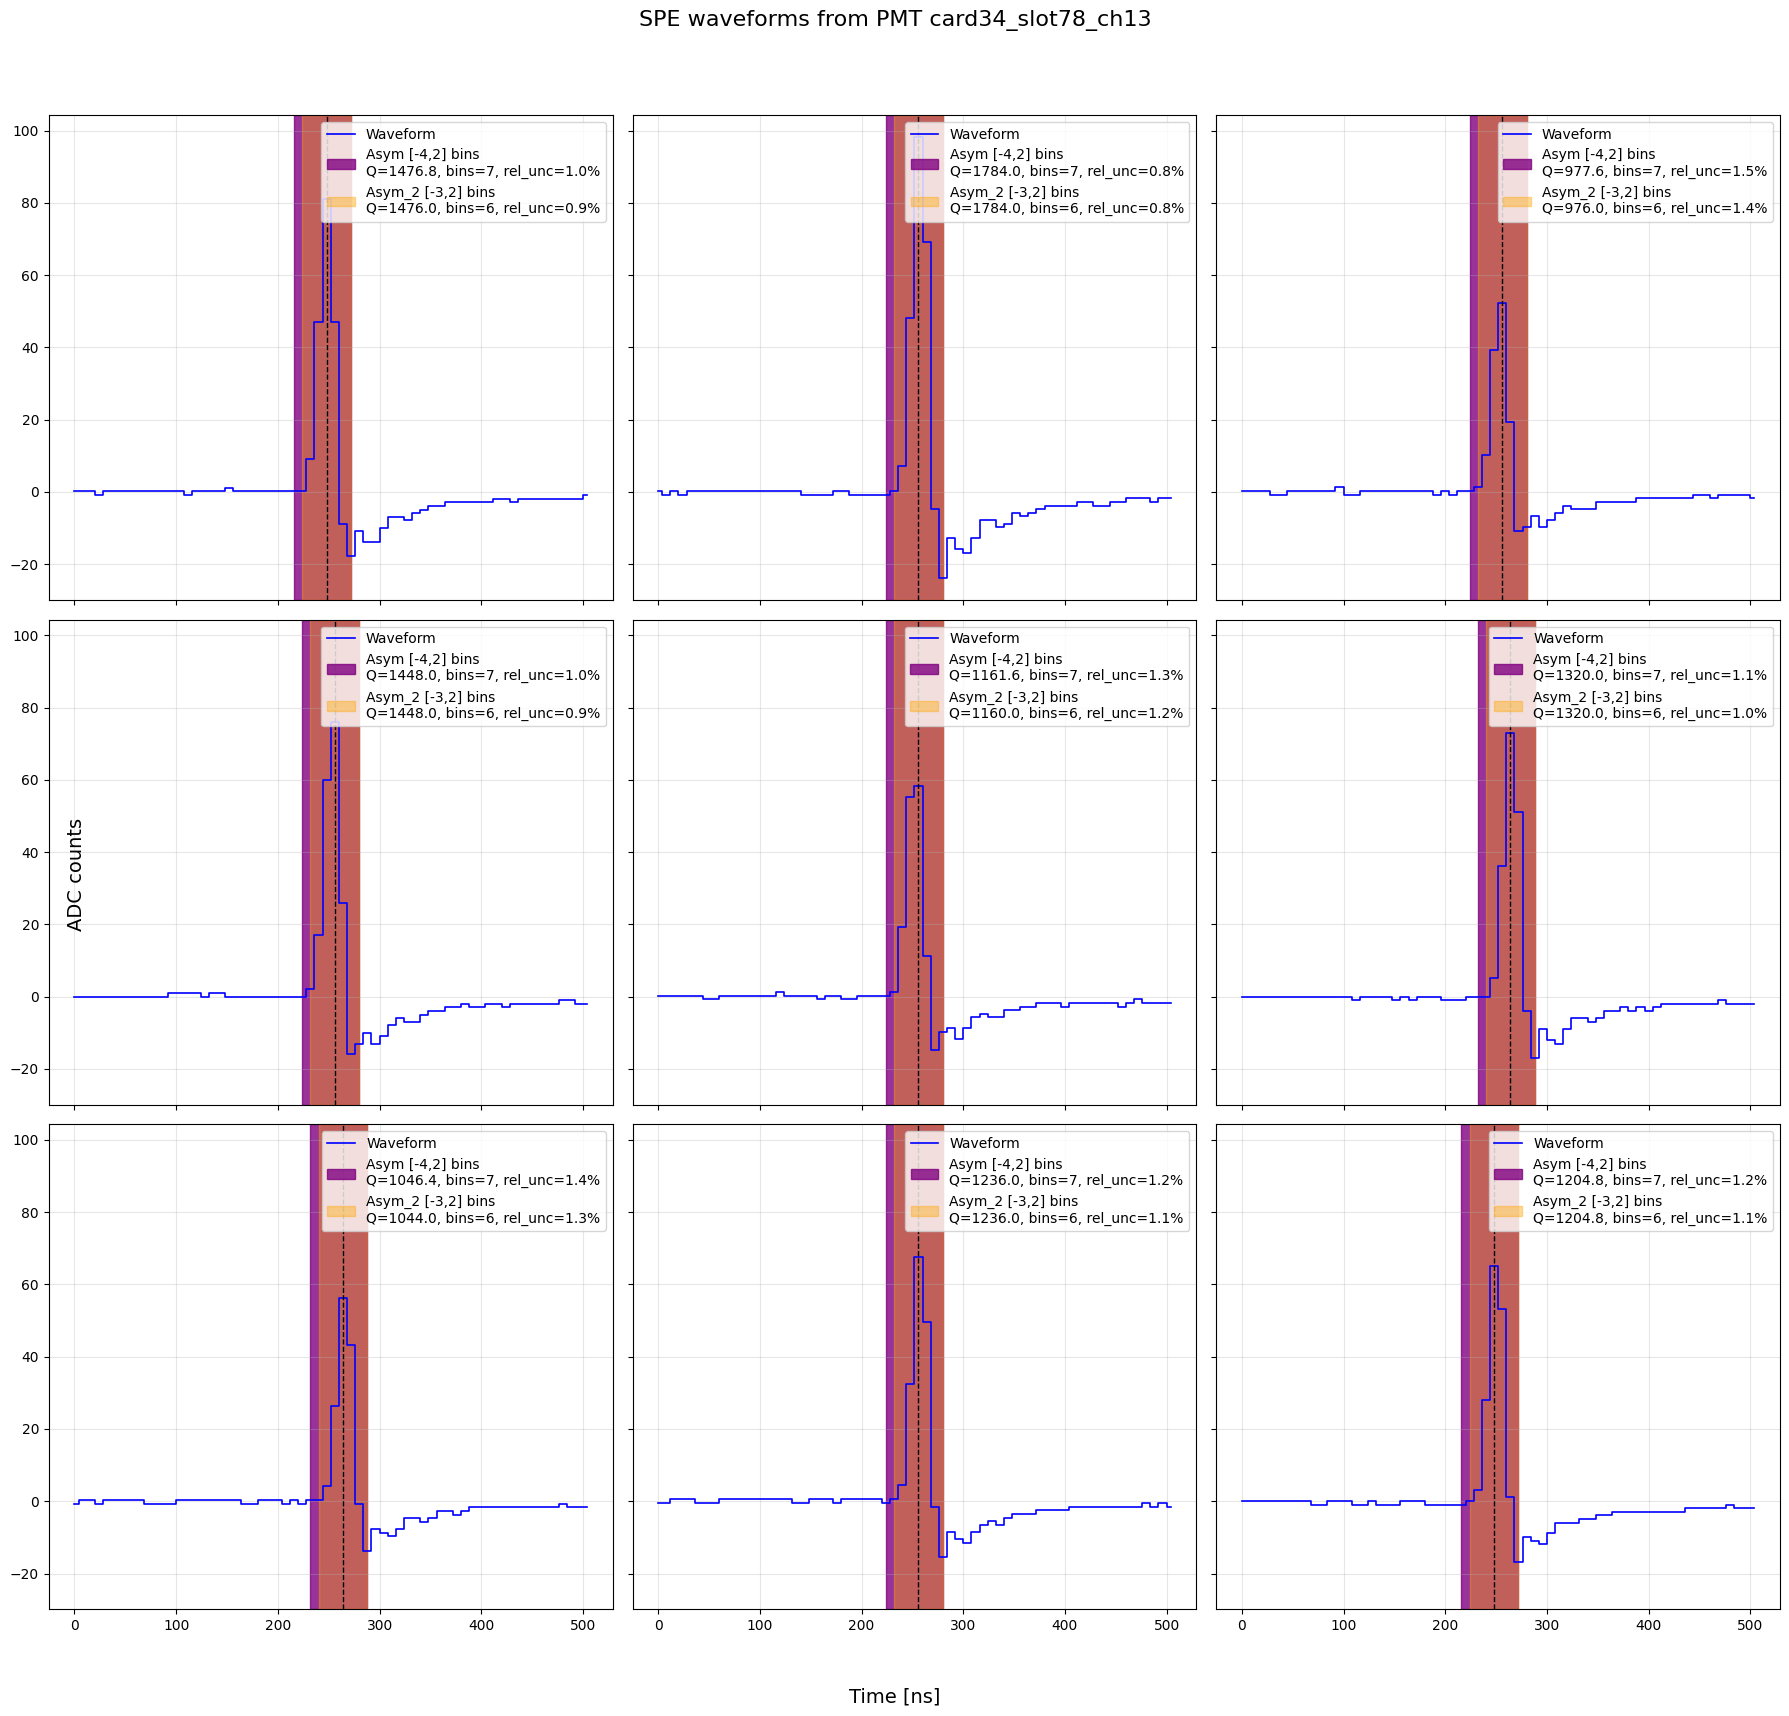

In [16]:
import numpy as np
import matplotlib.pyplot as plt

bin_width = 8.0  # 8 ns per sample/bin


signal_data = np.load(f"/scratch/elena/waveform_npz/run2521/{pmt_label}.npz")
control_data = np.load(f"/scratch/elena/waveform_npz/run2519/{pmt_label}.npz")

signal_waveforms = signal_data["waveforms"]
control_waveforms = control_data["waveforms"]

time_axis = np.arange(signal_waveforms.shape[1]) * bin_width

asym_window = (-4, +2)   
asym_window_2 = (-3, +2)    


sigma_sample = np.std(control_waveforms[:, :20])  # adjust baseline region if needed

n_rows, n_cols = 3,3
n_waveforms = n_rows * n_cols
threshold = 50  # ADC counts

valid_indices = [i for i, wf in enumerate(signal_waveforms) if np.max(wf) > threshold]


indices = np.random.choice(valid_indices, n_waveforms, replace=False)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 18), sharex=True, sharey=True)

for ax, idx in zip(axes.flat, indices):
    wf = signal_waveforms[idx]
    peak_idx = int(np.argmax(wf))
    
    # Asymmetric window
    start_asym = max(0, peak_idx + asym_window[0])
    end_asym   = min(len(wf), peak_idx + asym_window[1] + 1)
    bins_asym = end_asym - start_asym
    Q_asym = np.sum(np.clip(wf[start_asym:end_asym], 0, None)) * bin_width
    sigma_Q_asym = np.sqrt(bins_asym) * sigma_sample * bin_width
    rel_unc_asym = sigma_Q_asym / Q_asym * 100 if Q_asym > 0 else np.nan
    
    # Asymmetric window 2 
    start_asym_2 = max(0, peak_idx + asym_window_2[0])
    end_asym_2   = min(len(wf), peak_idx + asym_window_2[1] + 1)
    bins_asym_2 = end_asym_2 - start_asym_2
    Q_asym_2 = np.sum(np.clip(wf[start_asym_2:end_asym_2], 0, None)) * bin_width
    sigma_Q_asym_2 = np.sqrt(bins_asym_2) * sigma_sample * bin_width
    rel_unc_asym_2 = sigma_Q_asym_2 / Q_asym_2 * 100 if Q_asym_2 > 0 else np.nan
    
    ax.plot(time_axis, wf, drawstyle="steps-mid", lw=1.2, color="blue", label="Waveform")
    ax.axvline(peak_idx * bin_width, color="k", linestyle="--", lw=1)
   
    ax.axvspan(time_axis[start_asym], time_axis[end_asym-1] + bin_width,
               alpha=0.8, color="purple", label=(
                   f"Asym [{asym_window[0]},{asym_window[1]}] bins\n"
                   f"Q={Q_asym:.1f}, bins={bins_asym}, rel_unc={rel_unc_asym:.1f}%"))
    
    ax.axvspan(time_axis[start_asym_2], time_axis[end_asym_2-1] + bin_width,
               alpha=0.4, color="orange", label=(
                   f"Asym_2 [{asym_window_2[0]},{asym_window_2[1]}] bins\n"
                   f"Q={Q_asym_2:.1f}, bins={bins_asym_2}, rel_unc={rel_unc_asym_2:.1f}%"))
    
    ax.legend(fontsize=10, loc="upper right")
    ax.grid(alpha=0.3)

fig.text(0.5, 0.04, "Time [ns]", ha="center", fontsize=14)
fig.text(0.04, 0.5, "ADC counts", va="center", rotation="vertical", fontsize=14)
fig.suptitle(f"SPE waveforms from PMT {pmt_label}", fontsize=16)
plt.tight_layout(rect=[0, 0.07, 1, 0.95])
plt.show()

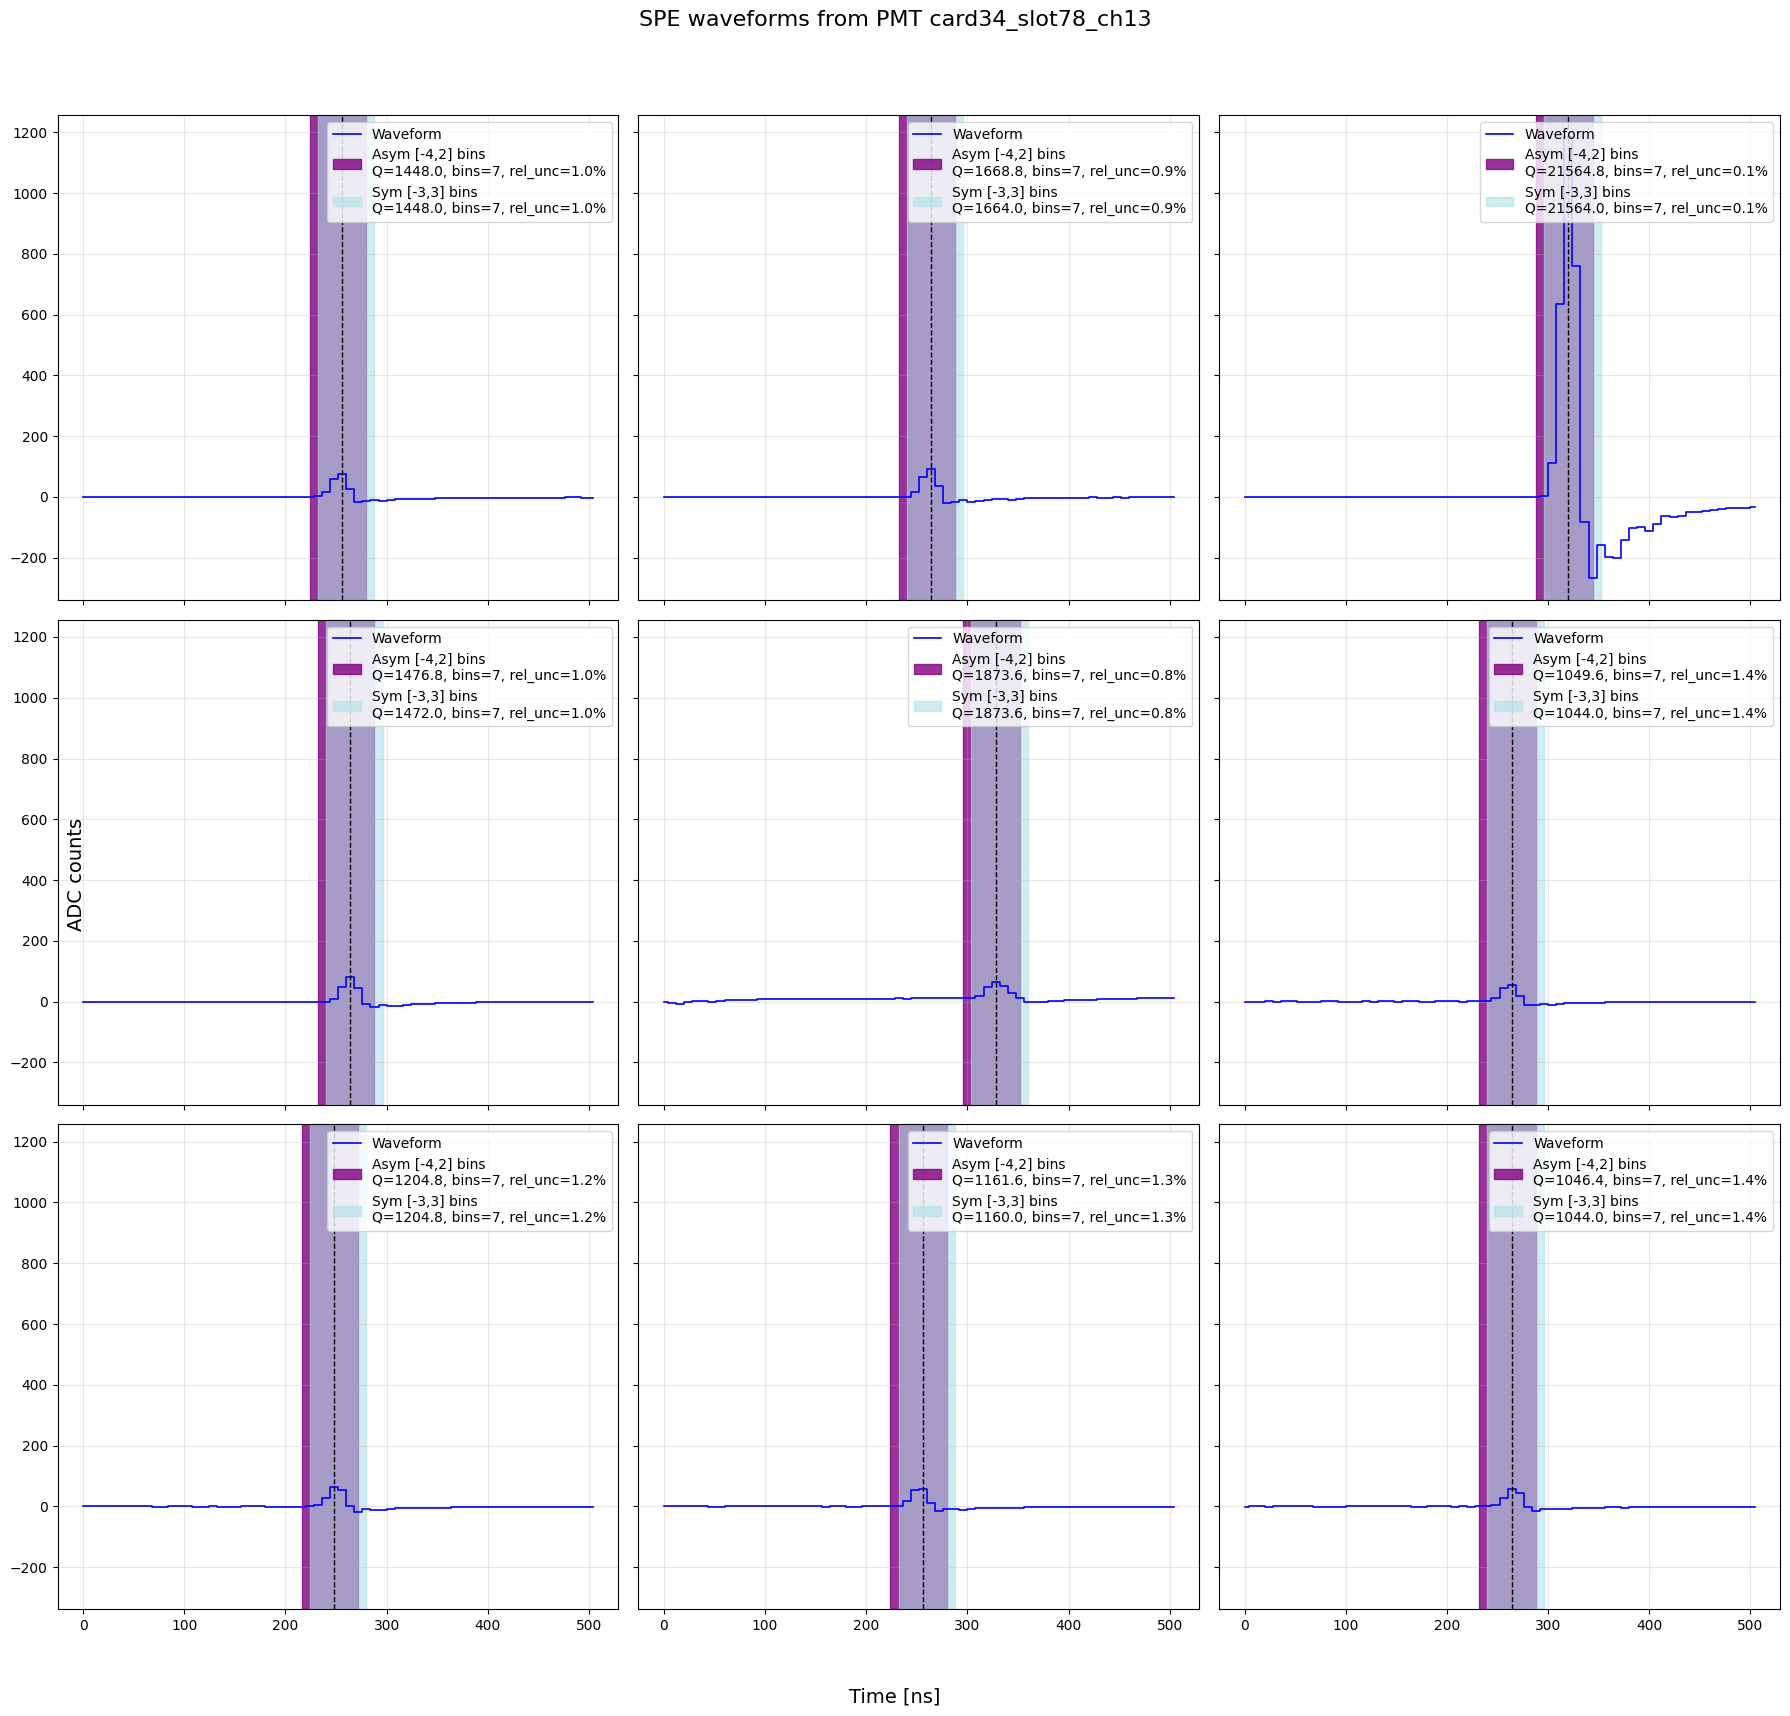

In [17]:
import numpy as np
import matplotlib.pyplot as plt

bin_width = 8.0  


signal_data = np.load(f"/scratch/elena/waveform_npz/run2521/{pmt_label}.npz")
control_data = np.load(f"/scratch/elena/waveform_npz/run2519/{pmt_label}.npz")

signal_waveforms = signal_data["waveforms"]
control_waveforms = control_data["waveforms"]

time_axis = np.arange(signal_waveforms.shape[1]) * bin_width

asym_window = (-4, +2)   
symmetric_window = (-3, +3)   

sigma_sample = np.std(control_waveforms[:, :20])  

n_rows, n_cols = 3,3
n_waveforms = n_rows * n_cols
threshold = 50  # ADC counts

valid_indices = [i for i, wf in enumerate(signal_waveforms) if np.max(wf) > threshold]

# Choose different random waveforms every run
indices = np.random.choice(valid_indices, n_waveforms, replace=False)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 18), sharex=True, sharey=True)

for ax, idx in zip(axes.flat, indices):
    wf = signal_waveforms[idx]
    peak_idx = int(np.argmax(wf))
    
    # Asymmetric window
    start_asym = max(0, peak_idx + asym_window[0])
    end_asym   = min(len(wf), peak_idx + asym_window[1] + 1)
    bins_asym = end_asym - start_asym
    Q_asym = np.sum(np.clip(wf[start_asym:end_asym], 0, None)) * bin_width
    sigma_Q_asym = np.sqrt(bins_asym) * sigma_sample * bin_width
    rel_unc_asym = sigma_Q_asym / Q_asym * 100 if Q_asym > 0 else np.nan
    
    # Symmetric window
    start_sym = max(0, peak_idx + symmetric_window[0])
    end_sym   = min(len(wf), peak_idx + symmetric_window[1] + 1)
    bins_sym = end_sym - start_sym
    Q_sym = np.sum(np.clip(wf[start_sym:end_sym], 0, None)) * bin_width
    sigma_Q_sym = np.sqrt(bins_sym) * sigma_sample * bin_width
    rel_unc_sym = sigma_Q_sym / Q_sym * 100 if Q_sym > 0 else np.nan
    
    ax.plot(time_axis, wf, drawstyle="steps-mid", lw=1.2, color="blue", label="Waveform")
    ax.axvline(peak_idx * bin_width, color="k", linestyle="--", lw=1)
   
    ax.axvspan(time_axis[start_asym], time_axis[end_asym-1] + bin_width,
               alpha=0.8, color="purple", label=(
                   f"Asym [{asym_window[0]},{asym_window[1]}] bins\n"
                   f"Q={Q_asym:.1f}, bins={bins_asym}, rel_unc={rel_unc_asym:.1f}%"))
    
    ax.axvspan(time_axis[start_sym], time_axis[end_sym-1] + bin_width,
               alpha=0.6, color="powderblue", label=(
                   f"Sym [{symmetric_window[0]},{symmetric_window[1]}] bins\n"
                   f"Q={Q_sym:.1f}, bins={bins_sym}, rel_unc={rel_unc_sym:.1f}%"))
    
    ax.legend(fontsize=10, loc="upper right")
    ax.grid(alpha=0.3)

fig.text(0.5, 0.04, "Time [ns]", ha="center", fontsize=14)
fig.text(0.04, 0.5, "ADC counts", va="center", rotation="vertical", fontsize=14)
fig.suptitle(f"SPE waveforms from PMT {pmt_label}", fontsize=16)
plt.tight_layout(rect=[0, 0.07, 1, 0.95])
plt.show()

- Cada trigger → una waveform de 64 samples (cada sample = 8 ns).

- Cada sample está en ADC counts (digitalización de la señal analógica del PMT).

Queremos medir el gain de cada PMT, es decir:


$$
G = \frac{Q_{\text{1 p.e.}}}{e}
$$

donde $Q_{\text{1 p.e.}}$ es la carga promedio de un solo fotoelectrón y $e$ es la carga elemental.



Pero en tu DAQ, no tienes directamente Coulombs, sino ADC counts.

Lo que hacemos para relacionarlas: 

Cada waveform → se integra (suma de samples × ancho de bin) para obtener una carga total en ADC·ns.

Esto es equivalente a medir el área del pulso. Esa área es proporcional a la carga real colectada en el ánodo del PMT.

Luego, haces un histograma de todas esas cargas (de un LED run). Verás un pedestal (0 p.e.), un primer pico (1 p.e.), y a veces un segundo pico (2 p.e.) si tienes buena estadística.

In [ ]:
signal_dir = "/scratch/elena/waveform_npz/run2521/"
control_dir = "/scratch/elena/waveform_npz/run2519/"

signal_files = [f for f in os.listdir(signal_dir) if f.endswith(".npz")]
control_files = [f for f in os.listdir(control_dir) if f.endswith(".npz")]

signal_pmts = set(f.replace(".npz", "") for f in signal_files)
control_pmts = set(f.replace(".npz", "") for f in control_files)

pmts_both = sorted(list(signal_pmts & control_pmts))

print(f"Number of PMTs in both files: {len(pmts_both)}")
print("Some examples:", pmts_both[:20])

Number of PMTs in both files: 1548
Some examples: ['card100_slot24_ch0', 'card100_slot24_ch1', 'card100_slot24_ch10', 'card100_slot24_ch11', 'card100_slot24_ch12', 'card100_slot24_ch13', 'card100_slot24_ch14', 'card100_slot24_ch15', 'card100_slot24_ch16', 'card100_slot24_ch17', 'card100_slot24_ch18', 'card100_slot24_ch2', 'card100_slot24_ch3', 'card100_slot24_ch4', 'card100_slot24_ch5', 'card100_slot24_ch6', 'card100_slot24_ch7', 'card100_slot24_ch8', 'card100_slot24_ch9', 'card101_slot20_ch0']


In [19]:
card_id = 100
slot_id = 24
channel_id = 16

pmt_label = f"card{card_id}_slot{slot_id}_ch{channel_id}"

signal_npz = f"/scratch/elena/waveform_npz/run2521/{pmt_label}.npz"    #signal run2521
control_npz = f"/scratch/elena/waveform_npz/run2519/{pmt_label}.npz"   #control run2519

In [20]:
signal_npz = os.path.join(signal_dir, pmt_label + ".npz")
control_npz = os.path.join(control_dir, pmt_label + ".npz")


pre_peak   = 4   # bins before max (for SPE)
post_peak  = 2   # bins after max (for SPE)
ped_window = 4   # symmetric window width (for pedestal)

def load_waveforms(npz_file):
    data = np.load(npz_file)
    return data["waveforms"]

signal_waveforms = load_waveforms(signal_npz)
control_waveforms = load_waveforms(control_npz)

def integrate_waveform_signal(wf, pre_peak=pre_peak, post_peak=post_peak):
    peak_idx = np.argmax(wf)
    start = max(0, peak_idx - pre_peak)
    end   = min(len(wf), peak_idx + post_peak + 1)
    return np.sum(wf[start:end])

def integrate_waveform_control(wf, window=ped_window):
    peak_idx = np.argmax(wf)
    half_w = window // 2
    start = max(0, peak_idx - half_w)
    end   = min(len(wf), peak_idx + half_w)
    return np.sum(wf[start:end])

charges_signal = np.array([integrate_waveform_signal(wf) for wf in signal_waveforms])
charges_control = np.array([integrate_waveform_control(wf) for wf in control_waveforms])



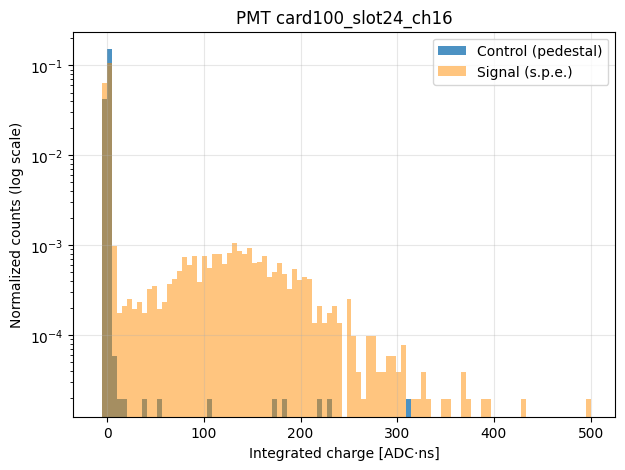

In [21]:
plt.figure(figsize=(7,5))
bins = np.linspace(-10, 500, 100)

plt.hist(charges_control, bins=bins, color = "#1f77b4", alpha=0.8, label="Control (pedestal)", density=True)
plt.hist(charges_signal, bins=bins, color="darkorange", alpha=0.5, label="Signal (s.p.e.)", density=True)

plt.yscale("log")
plt.xlabel("Integrated charge [ADC·ns]")
plt.ylabel("Normalized counts (log scale)")
plt.legend()
plt.grid(alpha=0.3)
plt.title(f"PMT {pmt_label}")
plt.show()

In [22]:
# NLL

def stable_nll(params, data):
    mu1, sigma1, mu2, sigma2, w = params
    if sigma1 <= 0 or sigma2 <= 0:    # sigma > 0, w in (0,1)
        return 1e300
    # clip w away from 0/1 for log stability
    w = float(np.clip(w, 1e-9, 1-1e-9))
    # logpdfs
    lp1 = norm.logpdf(data, loc=mu1, scale=sigma1)
    lp2 = norm.logpdf(data, loc=mu2, scale=sigma2)
    # log of mixture pdf: log( w*exp(lp1) + (1-w)*exp(lp2) ) = logsumexp( log(w)+lp1, log(1-w)+lp2 )
    a = np.log(w) + lp1
    b = np.log(1.0 - w) + lp2
    # use numpy logaddexp for stable log-sum-exp elementwise
    lpmix = np.logaddexp(a, b)
    # negative log-likelihood
    return -np.sum(lpmix)


#try multiple random starts

def fit_double_gauss_multistart(data, n_starts=12, verbose=True):
    best = None
    best_nll = np.inf

    # sensible heuristics from data
    p10, p30, p50, p70, p90 = np.percentile(data, [10,30,50,70,90])
    spe_candidates = data[(data>80) & (data<200)]
    mu2_guess = np.median(spe_candidates) if len(spe_candidates)>0 else p70

    # grid of initial guesses (small grid + some random perturbations)
    init_list = []
    mus1 = [0.0, p10, p30]
    mus2 = [mu2_guess, p70, p90]
    sigs = [3.0, 10.0, 20.0]
    ws = [0.1, 0.3, 0.5]

    for mu1 in mus1:
        for mu2 in mus2:
            for s1 in sigs:
                for s2 in sigs:
                    for w in ws:
                        init_list.append([mu1, s1, mu2, s2, w])
                        if len(init_list) >= n_starts:
                            break
                    if len(init_list) >= n_starts: break
                if len(init_list) >= n_starts: break
            if len(init_list) >= n_starts: break
        if len(init_list) >= n_starts: break

    # if still fewer than requested, add random inits
    rng = np.random.default_rng(12345)
    while len(init_list) < n_starts:
        mu1_r = float(rng.normal(loc=0.0, scale=5.0))
        mu2_r = float(rng.uniform(p50, p90+20))
        s1_r = float(rng.uniform(1.0, 15.0))
        s2_r = float(rng.uniform(5.0, 40.0))
        w_r  = float(rng.uniform(0.01, 0.9))
        init_list.append([mu1_r, s1_r, mu2_r, s2_r, w_r])

    bounds = [(-50, 50), (0.1, 100), ( -10, 500), (0.1, 200), (1e-6, 1-1e-6)]

    for i, p0 in enumerate(init_list):
        res = minimize(stable_nll, p0, args=(data,), method="L-BFGS-B", bounds=bounds,
                       options={'maxiter':1000})
        if not res.success and verbose:
            # keep trying, but print a short message
            pass
        if res.fun < best_nll:
            best_nll = res.fun
            best = res

    if best is None:
        raise RuntimeError("No successful fit found.")
    # reorder so mu1 < mu2 (pedestal = component with smaller mean)
    mu1f, s1f, mu2f, s2f, wf = best.x
    if mu1f > mu2f:
        # swap components
        mu1f, mu2f = mu2f, mu1f
        s1f, s2f = s2f, s1f
        wf = 1.0 - wf

    # attach diagnostics
    out = {
        'mu1': mu1f, 'sigma1': s1f, 'mu2': mu2f, 'sigma2': s2f, 'w': wf,
        'nll': best.fun, 'success': best.success, 'message': best.message, 'result_obj': best
    }
    if verbose:
        print("Best fit status:", out['success'], "-", out['message'])
        print(f"Negative log-likelihood: {out['nll']:.3f}")
    return out


# Run fit in data
fit_res = fit_double_gauss_multistart(charges_signal, n_starts=15, verbose=True)

mu1, sigma1, mu2, sigma2, w = fit_res['mu1'], fit_res['sigma1'], fit_res['mu2'], fit_res['sigma2'], fit_res['w']

print("\nFit final:")
print(f"mu1={mu1:.3f}, sigma1={sigma1:.3f}, mu2={mu2:.3f}, sigma2={sigma2:.3f}, w={w:.4f}")

Best fit status: True - b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Negative log-likelihood: 23296.632

Fit final:
mu1=0.724, sigma1=0.985, mu2=126.839, sigma2=77.078, w=0.8721


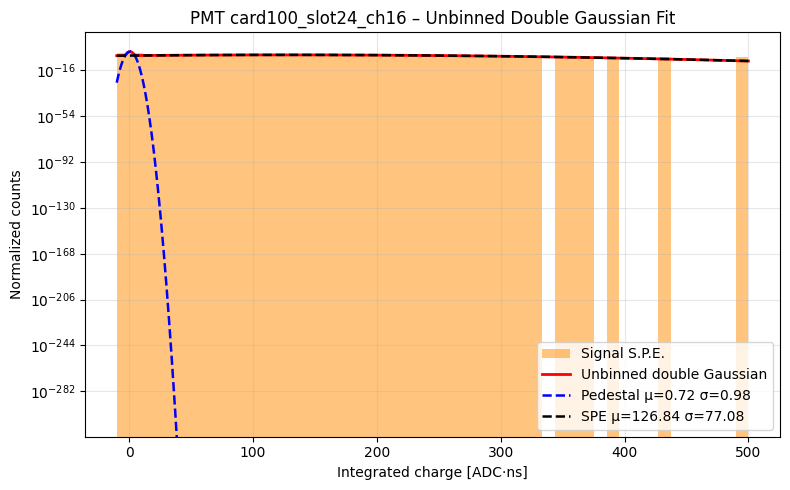

In [23]:
pmt_label = f"PMT {pmt_label}"  


def double_gauss_pdf(x, mu1, sigma1, mu2, sigma2, w):
    return w * norm.pdf(x, mu1, sigma1) + (1-w) * norm.pdf(x, mu2, sigma2)

plt.figure(figsize=(8,5))
bins = np.linspace(-10, 500, 50)

plt.hist(charges_signal, bins=bins, color="darkorange", alpha=0.5, label="Signal S.P.E.", density=True)

x_vals = np.linspace(-10, 500, 2000)
pdf_total = double_gauss_pdf(x_vals, mu1, sigma1, mu2, sigma2, w)
pdf_ped   = w * norm.pdf(x_vals, mu1, sigma1)
pdf_spe   = (1-w) * norm.pdf(x_vals, mu2, sigma2)

plt.plot(x_vals, pdf_total, 'r-', lw=2, label="Unbinned double Gaussian")
plt.plot(x_vals, pdf_ped, 'b--', lw=1.8, label=f"Pedestal μ={mu1:.2f} σ={sigma1:.2f}")
plt.plot(x_vals, pdf_spe, 'k--', lw=1.8, label=f"SPE μ={mu2:.2f} σ={sigma2:.2f}")

plt.yscale("log")
plt.xlabel("Integrated charge [ADC·ns]")
plt.ylabel("Normalized counts")
plt.title(f"{pmt_label} – Unbinned Double Gaussian Fit")
plt.yscale('log')  # si quieres ver la cola en log
plt.grid(alpha=0.3, which='both')
plt.legend()
plt.tight_layout()
plt.show()



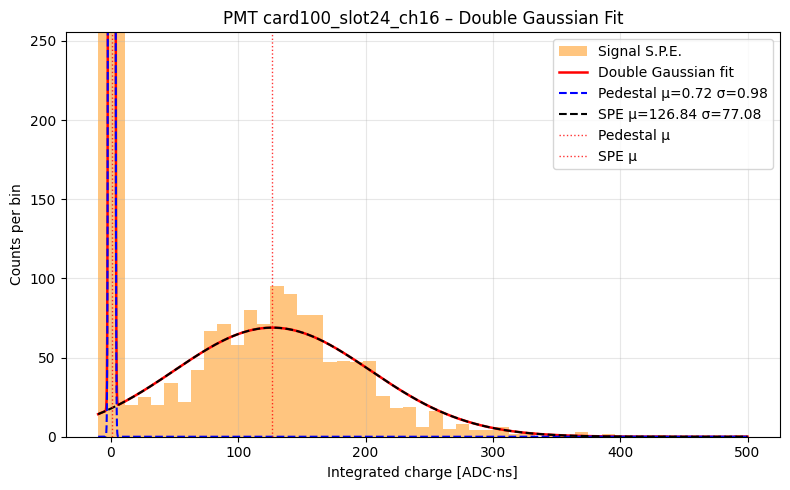

In [24]:
plt.figure(figsize=(8,5))
bins = np.linspace(-10, 500, 50)

# Raw counts
counts, bins, _ = plt.hist(charges_signal, bins=bins, color="darkorange", alpha=0.5, label="Signal S.P.E.", density=False)

bin_width = bins[1] - bins[0]
N = len(charges_signal)

x_vals = np.linspace(-10, 500, 2000)
pdf_total = double_gauss_pdf(x_vals, mu1, sigma1, mu2, sigma2, w)
pdf_ped   = w * norm.pdf(x_vals, mu1, sigma1)
pdf_spe   = (1-w) * norm.pdf(x_vals, mu2, sigma2)

pdf_total_counts = pdf_total * N * bin_width
pdf_ped_counts   = pdf_ped   * N * bin_width
pdf_spe_counts   = pdf_spe   * N * bin_width

plt.plot(x_vals, pdf_total_counts, 'r-', lw=1.8, label="Double Gaussian fit")
plt.plot(x_vals, pdf_ped_counts, 'b--', lw=1.5, label=f"Pedestal μ={mu1:.2f} σ={sigma1:.2f}")
plt.plot(x_vals, pdf_spe_counts, 'k--', lw=1.5, label=f"SPE μ={mu2:.2f} σ={sigma2:.2f}")

# Líneas verticales punteadas rojas para medias
plt.axvline(mu1, color='red', linestyle=':', lw=1, alpha=0.8, label=f"Pedestal μ")
plt.axvline(mu2, color='red', linestyle=':', lw=1, alpha=0.8, label=f"SPE μ")

plt.ylim(0, np.max(counts)*0.05)   # limita el eje y para ver el SPE
plt.xlabel("Integrated charge [ADC·ns]")
plt.ylabel("Counts per bin")
plt.title(f"{pmt_label} – Double Gaussian Fit")
plt.grid(alpha=0.3, which='both')
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
# --- Plot con histograma y Double Gaussian Fit ---
plt.figure(figsize=(8,5))
bins = np.linspace(-10, 500, 50)

# histograma normalizado de los datos
plt.hist(data_signal, bins=bins, color="darkorange", alpha=0.5, density=True, label="Signal S.P.E.")

# curvas del ajuste
x_vals = np.linspace(-10, 500, 2000)
pdf_total = double_gauss_pdf(x_vals, mu1, sigma1, mu2, sigma2, w)
pdf_ped   = w * norm.pdf(x_vals, mu1, sigma1)
pdf_spe   = (1-w) * norm.pdf(x_vals, mu2, sigma2)

# dibujar curvas
plt.plot(x_vals, pdf_total, 'r-', lw=2, label="Unbinned double Gaussian")
plt.plot(x_vals, pdf_ped, 'b--', lw=1.8, label=f"Pedestal μ={mu1:.1f}±{err_mu1:.1f}")
plt.plot(x_vals, pdf_spe, 'k--', lw=1.8, label=f"SPE μ={mu2:.1f}±{sigma2:.1f}")

# formato
plt.xlabel("Integrated charge [ADC·ns]")
plt.ylabel("Normalized counts")
plt.title(f"PMT {pmt_label} – Unbinned Double Gaussian Fit")
plt.grid(alpha=0.3, which='both')
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'data_signal' is not defined

<Figure size 800x500 with 0 Axes>

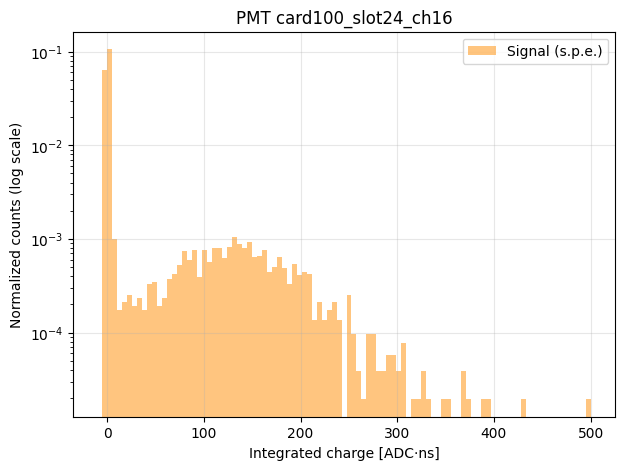

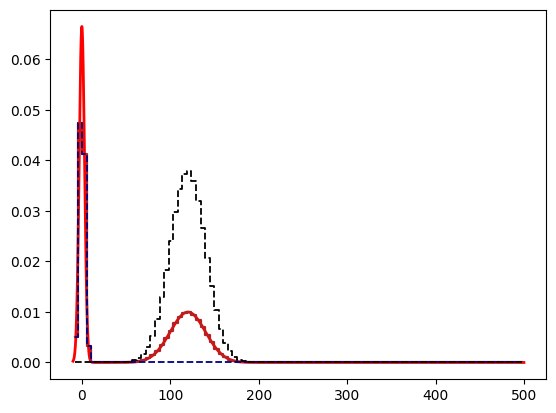

In [ ]:
charges_signal = np.array([integrate_waveform_signal(wf) for wf in signal_waveforms])

# --- Plot both distributions ---
plt.figure(figsize=(7,5))
bins = np.linspace(-10, 500, 100)

plt.hist(charges_signal, bins=bins, color="darkorange", alpha=0.5, label="Signal (s.p.e.)", density=True)

plt.yscale("log")
plt.xlabel("Integrated charge [ADC·ns]")
plt.ylabel("Normalized counts (log scale)")
plt.legend()
plt.grid(alpha=0.3)
plt.title(f"PMT {pmt_label}")
plt.show()


# === OVERLAY: modelo sobre tu histograma en log ===

# 1) Fit unbinned (línea suave)
x_vals = np.linspace(bins.min(), bins.max(), 2000)
pdf_total = double_gauss_pdf(x_vals, mu1, sigma1, mu2, sigma2, w)
plt.plot(x_vals, pdf_total, 'r-', lw=2, zorder=3, label="Double Gauss Fit (unbinned)")

# 2) Modelo binned (para que cuadre con las barras en log)
edges = bins
widths = np.diff(edges)

# densidad esperada por bin = ΔCDF / Δx
cdf1 = norm.cdf((edges - mu1)/sigma1)
cdf2 = norm.cdf((edges - mu2)/sigma2)
dens_binned_total = (w*(cdf1[1:] - cdf1[:-1]) + (1-w)*(cdf2[1:] - cdf2[:-1])) / widths
centers = 0.5*(edges[:-1] + edges[1:])

plt.step(centers, dens_binned_total, where='mid', lw=1.6, color='firebrick',
         zorder=3, label="Model (binned expectation)")

# Componentes (también en representación binned)
dens_ped = (w*(norm.cdf((edges[1:] - mu1)/sigma1) - norm.cdf((edges[:-1] - mu1)/sigma1))) / widths
dens_spe = ((1-w)*(norm.cdf((edges[1:] - mu2)/sigma2) - norm.cdf((edges[:-1] - mu2)/sigma2))) / widths

# Rescale del SPE SOLO para visibilidad (no afecta al fit)
scale_spe = 0.8 * np.max(dens_ped) / max(np.max(dens_spe), 1e-300)
plt.step(centers, dens_ped, where='mid', lw=1.3, ls='--', color='navy',
         zorder=3, label=f"Pedestal μ={mu1:.1f}±{err_mu1:.1f}")
plt.step(centers, dens_spe*scale_spe, where='mid', lw=1.3, ls='--', color='k',
         zorder=3, label=f"SPE μ={mu2:.1f}±{sigma2:.1f} (rescaled for vis)")

# (tu yscale, labels, grid, legend y título se mantienen como ya los tienes)


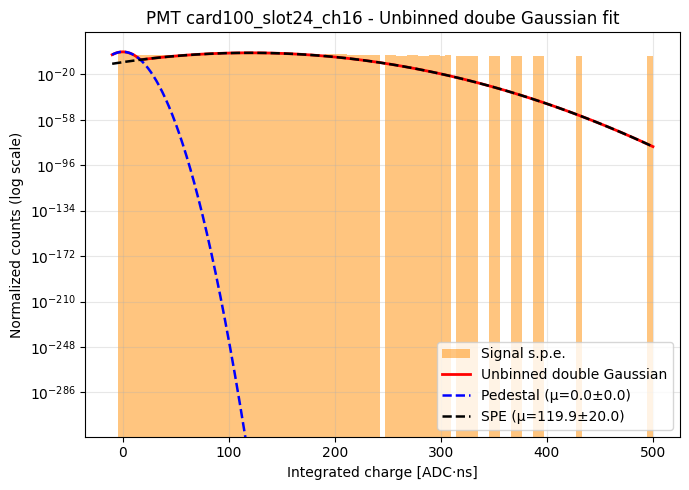

In [ ]:
# --- Histograma de tus datos (sin tocar nada) ---
plt.figure(figsize=(7,5))
bins = np.linspace(-10, 500, 100)

counts, edges, _ = plt.hist(
    charges_signal, bins=bins, color="darkorange", alpha=0.5, 
    label="Signal s.p.e.", density=True
)

# --- Overlay del ajuste ---
x_vals = np.linspace(bins.min(), bins.max(), 2000)
pdf_total = double_gauss_pdf(x_vals, mu1, sigma1, mu2, sigma2, w)
pdf_ped = w*norm.pdf(x_vals, mu1, sigma1)
pdf_spe = (1-w)*norm.pdf(x_vals, mu2, sigma2)

# Curva total (ajuste completo)
plt.plot(x_vals, pdf_total, 'r-', lw=2, label="Unbinned double Gaussian")

# Pedestal (componente 1)
plt.plot(x_vals, pdf_ped, 'b--', lw=1.8, label=f"Pedestal (μ={mu1:.1f}±{err_mu1:.1f})")

# SPE (componente 2, con rescale para visibilidad)
ped_max = np.max(pdf_ped)
spe_max = np.max(pdf_spe)
scale_factor = 0.8 * ped_max / spe_max   # SPE ~80% de altura del pedestal
pdf_spe_vis = pdf_spe * scale_factor
plt.plot(x_vals, pdf_spe, 'k--', lw=1.8, label=f"SPE (μ={mu2:.1f}±{sigma2:.1f})")

# --- Formato ---
plt.yscale("log")
plt.xlabel("Integrated charge [ADC·ns]")
plt.ylabel("Normalized counts (log scale)")
plt.legend()
plt.grid(alpha=0.3, which='both')
plt.title(f"PMT {pmt_label} - Unbinned doube Gaussian fit")
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# --- Directories ---
signal_dir = "/scratch/elena/waveform_npz/run2521/"
control_dir = "/scratch/elena/waveform_npz/run2519/"

# --- Select PMT ---
card_id = 100
slot_id = 24
channel_id = 16
pmt_label = f"card{card_id}_slot{slot_id}_ch{channel_id}"

signal_npz = os.path.join(signal_dir, pmt_label + ".npz")
control_npz = os.path.join(control_dir, pmt_label + ".npz")

# --- Integration windows ---
pre_peak   = 4   # bins before max (SPE)
post_peak  = 2   # bins after max (SPE)
ped_window = 4   # symmetric window width (pedestal)

# --- Load waveforms ---
def load_waveforms(npz_file):
    data = np.load(npz_file)
    return data["waveforms"]

signal_waveforms = load_waveforms(signal_npz)
control_waveforms = load_waveforms(control_npz)

# --- Integration functions ---
def integrate_waveform_signal(wf, pre_peak=pre_peak, post_peak=post_peak):
    peak_idx = np.argmax(wf)
    start = max(0, peak_idx - pre_peak)
    end   = min(len(wf), peak_idx + post_peak + 1)
    return np.sum(wf[start:end])

def integrate_waveform_control(wf, window=ped_window):
    peak_idx = np.argmax(wf)
    half_w = window // 2
    start = max(0, peak_idx - half_w)
    end   = min(len(wf), peak_idx + half_w)
    return np.sum(wf[start:end])

charges_signal = np.array([integrate_waveform_signal(wf) for wf in signal_waveforms])
charges_control = np.array([integrate_waveform_control(wf) for wf in control_waveforms])

# --- Mode window finder with optional ADC range ---
def find_modal_window(charges, adc_range=None, bins=200, threshold_frac=0.2, min_width=20):
    charges = np.array(charges)
    if adc_range is not None:
        lo_cut, hi_cut = adc_range
        charges = charges[(charges > lo_cut) & (charges < hi_cut)]
    
    hist, edges = np.histogram(charges, bins=bins)
    bin_centers = 0.5*(edges[1:] + edges[:-1])
    
    max_bin = np.argmax(hist)
    mode_est = bin_centers[max_bin]
    
    threshold = threshold_frac * hist[max_bin]
    left = max_bin
    right = max_bin
    while left > 0 and hist[left] > threshold:
        left -= 1
    while right < len(hist)-1 and hist[right] > threshold:
        right += 1
    
    lo = max(bin_centers[left], adc_range[0] if adc_range else bin_centers[left])
    hi = min(bin_centers[right], adc_range[1] if adc_range else bin_centers[right])
    if hi - lo < min_width:
        hi = lo + min_width
    
    selected = charges[(charges > lo) & (charges < hi)]
    return mode_est, lo, hi, selected

# --- Unbinned Gaussian MLE fit ---
def fit_gaussian_unbinned(data):
    data = np.array(data)
    if len(data) < 10:
        return np.nan, np.nan, False
    
    def nll(params):
        mu, sigma = params
        if sigma <= 0:
            return np.inf
        return 0.5 * np.sum(((data - mu)/sigma)**2 + np.log(2*np.pi*sigma**2))
    
    mu0, sigma0 = np.mean(data), np.std(data)
    result = minimize(nll, x0=[mu0, sigma0], method="Nelder-Mead")
    
    if result.success:
        mu_fit, sigma_fit = result.x
        return mu_fit, sigma_fit, True
    else:
        return mu0, sigma0, False

# --- Fit pedestal ---
ped_mode, ped_lo, ped_hi, ped_sel = find_modal_window(charges_control, adc_range=(-50,50))
mu_ped, sigma_ped, ok_ped = fit_gaussian_unbinned(ped_sel)

# --- Fit SPE with fixed range [80,200] ---
spe_mode, spe_lo, spe_hi, spe_sel = find_modal_window(charges_signal, adc_range=(80,200))
mu_spe, sigma_spe, ok_spe = fit_gaussian_unbinned(spe_sel)

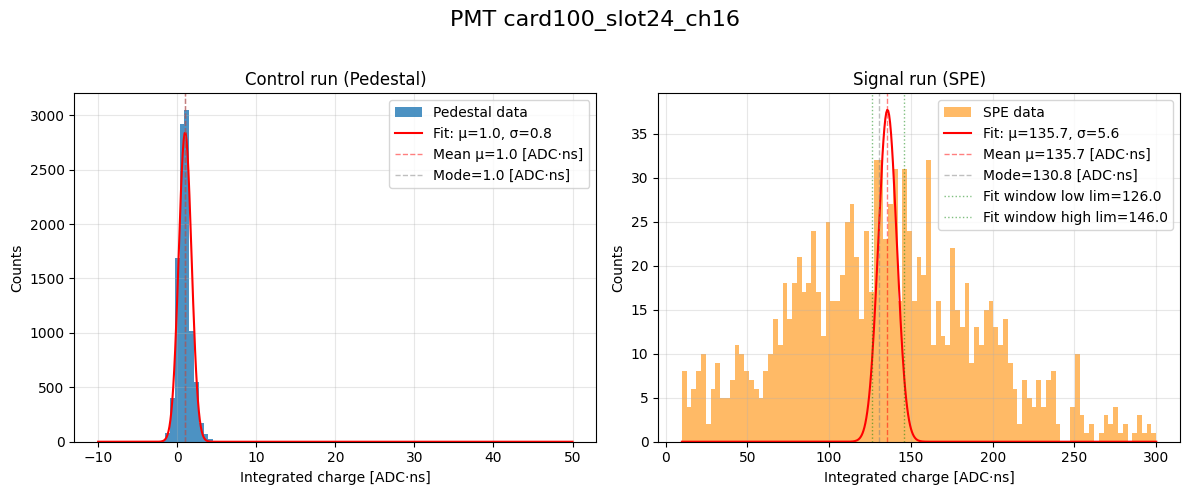

In [ ]:

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Control (pedestal)
ax = axes[0]
bins_ped = np.linspace(-10, 50, 100)
hist_ped, edges_ped, _ = ax.hist(charges_control, bins=bins_ped, color = "#1f77b4", alpha=0.8, label="Pedestal data")
x_vals = np.linspace(-10, 50, 500)
if ok_ped:
    bin_width = edges_ped[1] - edges_ped[0]
    y_fit = (len(ped_sel) * bin_width) * (1/(np.sqrt(2*np.pi)*sigma_ped)) * np.exp(-0.5*((x_vals-mu_ped)/sigma_ped)**2)
    ax.plot(x_vals, y_fit, 'r-', lw=1.5, label=f"Fit: μ={mu_ped:.1f}, σ={sigma_ped:.1f}")
ax.axvline(mu_ped, color="red", ls="--", lw=1, alpha=0.5, label=f"Mean μ={mu_ped:.1f} [ADC·ns]")
ax.axvline(ped_mode, color="gray", ls="--", lw=1, alpha=0.5, label=f"Mode={ped_mode:.1f} [ADC·ns]")
ax.set_xlabel("Integrated charge [ADC·ns]")
ax.set_ylabel("Counts")
ax.set_title("Control run (Pedestal)")
ax.legend()
ax.grid(alpha=0.3)

# Signal (SPE)
ax = axes[1]
bins_spe = np.linspace(10, 300, 100)
hist_spe, edges_spe, _ = ax.hist(charges_signal, bins=bins_spe, color = "darkorange", alpha=0.6, label="SPE data")
x_vals = np.linspace(10, 300, 500)
if ok_spe:
    bin_width = edges_spe[1] - edges_spe[0]
    y_fit = (len(spe_sel) * bin_width) * (1/(np.sqrt(2*np.pi)*sigma_spe)) * np.exp(-0.5*((x_vals-mu_spe)/sigma_spe)**2)
    ax.plot(x_vals, y_fit, 'r-', lw=1.5, label=f"Fit: μ={mu_spe:.1f}, σ={sigma_spe:.1f}")
ax.axvline(mu_spe, color="red", ls="--", lw=1, alpha=0.5, label=f"Mean μ={mu_spe:.1f} [ADC·ns]")
ax.axvline(spe_mode, color="gray", ls="--", lw=1, alpha=0.5, label=f"Mode={spe_mode:.1f} [ADC·ns]")
ax.axvline(spe_lo, color="green", ls=":", lw=1, alpha=0.5, label=f"Fit window low lim={spe_lo:.1f}")
ax.axvline(spe_hi, color="green", ls=":", lw=1, alpha=0.5, label=f"Fit window high lim={spe_hi:.1f}")
ax.set_xlabel("Integrated charge [ADC·ns]")
ax.set_ylabel("Counts")
ax.set_title("Signal run (SPE)")
ax.legend()
ax.grid(alpha=0.3)

plt.suptitle(f"PMT {pmt_label}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

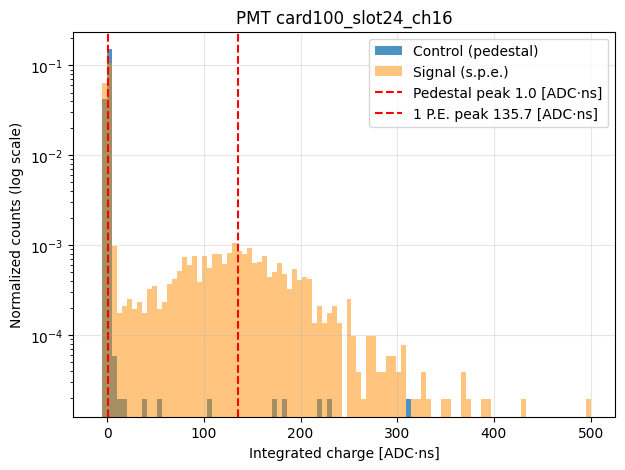

In [ ]:

# --- Plot both distributions ---
plt.figure(figsize=(7,5))
bins = np.linspace(-10, 500, 100)

plt.hist(charges_control, bins=bins, color = "#1f77b4", alpha=0.8, label="Control (pedestal)", density=True)
plt.hist(charges_signal, bins=bins, color="darkorange", alpha=0.5, label="Signal (s.p.e.)", density=True)

plt.axvline(mu_ped, color="red", ls="--", lw=1.5, alpha=1, label=f"Pedestal peak {mu_ped:.1f} [ADC·ns]")
plt.axvline(mu_spe, color="red", ls="--", lw=1.5, alpha=1, label=f"1 P.E. peak {mu_spe:.1f} [ADC·ns]")

plt.yscale("log")
plt.xlabel("Integrated charge [ADC·ns]")
plt.ylabel("Normalized counts (log scale)")
plt.legend()
plt.grid(alpha=0.3)
plt.title(f"PMT {pmt_label}")
plt.show()


## ------------------------------------------------------------------------------------------------------------------------------

In [ ]:
def integrate_waveform(wf, window_asym=(-4, +2), search_range_ns=None):
    """
    Integra un waveform en torno a su máximo dentro de un rango de tiempo en ns.
    
    wf: array de waveform
    window_asym: tupla (bins_antes, bins_despues)
    search_range_ns: tupla (start_ns, end_ns) para buscar el máximo
    """
    # Convertir rango de tiempo a bins
    if search_range_ns is not None:
        start_idx = max(0, int(search_range_ns[0] / bin_width))
        end_idx   = min(len(wf), int(search_range_ns[1] / bin_width))
        if start_idx >= end_idx:
            raise ValueError(f"search_range {search_range_ns} fuera del tamaño del waveform")
        peak_idx = start_idx + np.argmax(wf[start_idx:end_idx])
    else:
        peak_idx = np.argmax(wf)

    # Ventana de integración
    start = max(0, peak_idx + window_asym[0])
    end   = min(len(wf), peak_idx + window_asym[1] + 1)

    return np.sum(wf[start:end])      #* bin_width --> no multplicar por 8ns


# Control run (pedestal), buscar máximo cerca de 0 ns
charges_control = [integrate_waveform(wf, window_asym=(-1, +1), search_range_ns=(0, 20))
                   for wf in control_waveforms]

# Signal run (SPE), buscar máximo entre 100 y 300 ns
charges_signal = [integrate_waveform(wf, window_asym=(-4, +2), search_range_ns=(100, 300))
                  for wf in signal_waveforms]

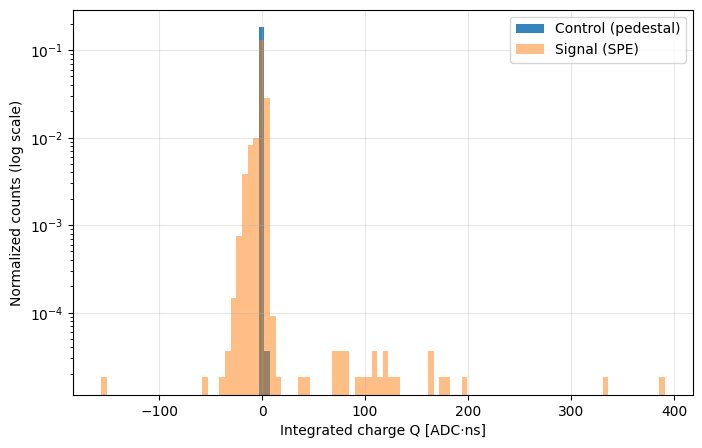

In [ ]:
all_charges = charges_control + charges_signal
min_charge = min(all_charges)
max_charge = max(all_charges)
bins = 100

plt.figure(figsize=(8,5))
plt.hist(charges_control, bins=bins, alpha=0.9, label="Control (pedestal)",
         density=True, range=(min_charge, max_charge))
plt.hist(charges_signal, bins=bins, alpha=0.5, label="Signal (SPE)",
         density=True, range=(min_charge, max_charge))
plt.yscale("log")
plt.xlabel("Integrated charge Q [ADC·ns]")
plt.ylabel("Normalized counts (log scale)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
#Function to find the modal window


def find_modal_window(charges, adc_range=None, bins=200, threshold_frac=0.05, min_width=20):
    """
    Find the region around the histogram mode (most frequent bin).
    Returns: mode_estimate, lo, hi, selected_data
    """
    if adc_range is not None:
        lo_cut, hi_cut = adc_range
        charges = np.array(charges)
        charges = charges[(charges > lo_cut) & (charges < hi_cut)]
    
    hist, edges = np.histogram(charges, bins=bins)
    bin_centers = 0.5 * (edges[1:] + edges[:-1])

    max_bin = np.argmax(hist)
    mode_est = bin_centers[max_bin]

    threshold = threshold_frac * hist[max_bin]
    left = max_bin
    right = max_bin
    while left > 0 and hist[left] > threshold:
        left -= 1
    while right < len(hist) - 1 and hist[right] > threshold:
        right += 1

    lo = bin_centers[left]
    hi = bin_centers[right]

    if hi - lo < min_width:
        hi = lo + min_width

    selected = charges[(charges > lo) & (charges < hi)]

    return mode_est, lo, hi, selected

In [ ]:
#Unbinned Gaussian MLE fit

from scipy.optimize import minimize

def fit_gaussian_unbinned(data):
    """
    Fit Gaussian to unbinned data via MLE.
    Returns: mu, sigma, success_flag
    """
    data = np.array(data)
    if len(data) < 10:
        return np.nan, np.nan, False
    
    # negative log-likelihood
    def nll(params):
        mu, sigma = params
        if sigma <= 0:
            return np.inf
        return 0.5 * np.sum(((data - mu)/sigma)**2 + np.log(2*np.pi*sigma**2))

    mu0, sigma0 = np.mean(data), np.std(data)
    result = minimize(nll, x0=[mu0, sigma0], method="Nelder-Mead")
    
    if result.success:
        mu_fit, sigma_fit = result.x
        return mu_fit, sigma_fit, True
    else:
        return mu0, sigma0, False

In [ ]:
#plotting function

from scipy.stats import norm


def plot_fit(data_window, mu, sigma, title="", full_data=None, window=None, bins=60, logy=False):
    plt.figure(figsize=(8,5))
    
    # Histograma de todos los datos
    if full_data is not None:
        plt.hist(full_data, bins=bins, alpha=0.3, label="All data", color="gray", density=True)
    
    # Histograma de la ventana de fit
    plt.hist(data_window, bins=bins, alpha=0.7, label="Fit window", color="dodgerblue", density=True)
    
    # Curva gaussiana
    x = np.linspace(min(data_window), max(data_window), 300)
    pdf = norm.pdf(x, mu, sigma)
    plt.plot(x, pdf, "r-", lw=2, label=f"Gaussian μ={mu:.1f}, σ={sigma:.1f}")
    
    # Líneas del window
    if window is not None:
        plt.axvline(window[0], color="k", ls="--", lw=1)
        plt.axvline(window[1], color="k", ls="--", lw=1)
    
    plt.title(title)
    plt.xlabel("Integrated charge [ADC·ns]")
    plt.ylabel("Normalized counts")
    plt.legend()
    plt.grid(alpha=0.3)
    if logy:
        plt.yscale("log")
    plt.show()


Control (pedestal) fit:
  Mode estimate        : 0.011 ADC·ns
  Fit window           : [-0.016, 19.984] ADC·ns  (n=7779)
  Gaussian MLE (μ, σ)  : (0.495 ± 0.005, 0.449)  success=True


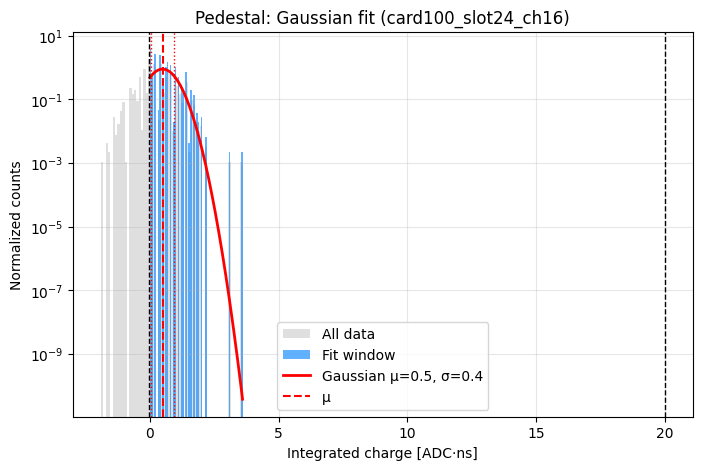


Signal (s.p.e.) fit:
  Mode estimate        : 83.889 ADC·ns
  Fit window           : [83.889, 103.889] ADC·ns  (n=2)
  Gaussian MLE (μ, σ)  : (nan ± nan, nan)  success=False


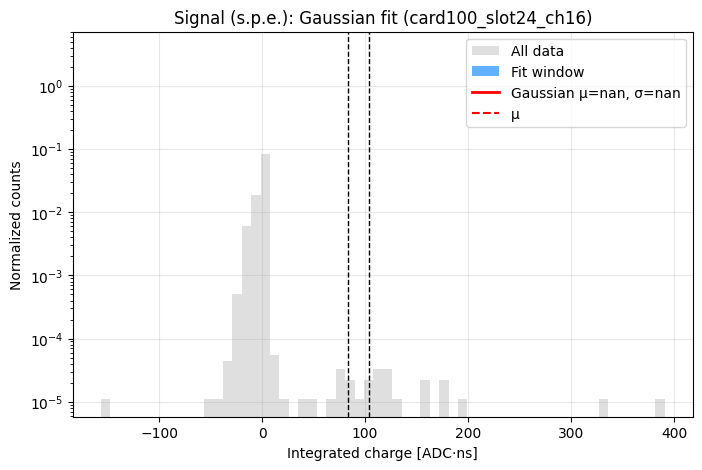


Gain (μ_spe − μ_ped)  : nan ± nan  [ADC·ns]


In [ ]:
# --- Pedestal (control) ---
ped_mode, ped_lo, ped_hi, ped_sel = find_modal_window(
    charges_control,               # <-- tus cargas del run de control
    adc_range=(-10, 10),           # rango donde está el pedestal
    # threshold_frac=0.2, min_width=30
)
mu_ped, sigma_ped, ok_ped = fit_gaussian_unbinned(ped_sel)
err_mu_ped = sigma_ped / np.sqrt(len(ped_sel))

print("Control (pedestal) fit:")
print(f"  Mode estimate        : {ped_mode:.3f} ADC·ns")
print(f"  Fit window           : [{ped_lo:.3f}, {ped_hi:.3f}] ADC·ns  (n={len(ped_sel)})")
print(f"  Gaussian MLE (μ, σ)  : ({mu_ped:.3f} ± {err_mu_ped:.3f}, {sigma_ped:.3f})  success={ok_ped}")

# Improved plotting
plt.figure(figsize=(8,5))

# All data histogram
plt.hist(charges_control, bins=60, density=True, color="gray", alpha=0.25, label="All data")

# Fit window histogram
plt.hist(ped_sel, bins=60, density=True, color="dodgerblue", alpha=0.7, label="Fit window")

# Gaussian curve
x = np.linspace(min(ped_sel), max(ped_sel), 300)
pdf = norm.pdf(x, mu_ped, sigma_ped)
plt.plot(x, pdf, "r-", lw=2, label=f"Gaussian μ={mu_ped:.1f}, σ={sigma_ped:.1f}")

# Lines: mean ± sigma
plt.axvline(mu_ped, color="r", ls="--", lw=1.5, label="μ")
plt.axvline(mu_ped+sigma_ped, color="r", ls=":", lw=1)
plt.axvline(mu_ped-sigma_ped, color="r", ls=":", lw=1)

# Fit window
plt.axvline(ped_lo, color="k", ls="--", lw=1)
plt.axvline(ped_hi, color="k", ls="--", lw=1)

plt.title(f"Pedestal: Gaussian fit ({pmt_label})")
plt.xlabel("Integrated charge [ADC·ns]")
plt.ylabel("Normalized counts")
plt.legend()
plt.grid(alpha=0.3)
plt.yscale("log")
plt.show()

# --- s.p.e. (signal) ---
spe_mode, spe_lo, spe_hi, spe_sel = find_modal_window(
    charges_signal,                # <-- tus cargas del run de señal
    adc_range=(80, 220),           # busca el pico s.p.e. aquí (ajústalo si hace falta)
    # threshold_frac=0.2, min_width=40
)
mu_spe, sigma_spe, ok_spe = fit_gaussian_unbinned(spe_sel)
err_mu_spe = sigma_spe / np.sqrt(len(spe_sel))

print("\nSignal (s.p.e.) fit:")
print(f"  Mode estimate        : {spe_mode:.3f} ADC·ns")
print(f"  Fit window           : [{spe_lo:.3f}, {spe_hi:.3f}] ADC·ns  (n={len(spe_sel)})")
print(f"  Gaussian MLE (μ, σ)  : ({mu_spe:.3f} ± {err_mu_spe:.3f}, {sigma_spe:.3f})  success={ok_spe}")

# Improved plotting
plt.figure(figsize=(8,5))

# All data histogram
plt.hist(charges_signal, bins=60, density=True, color="gray", alpha=0.25, label="All data")

# Fit window histogram
plt.hist(spe_sel, bins=60, density=True, color="dodgerblue", alpha=0.7, label="Fit window")

# Gaussian curve
x = np.linspace(min(spe_sel), max(spe_sel), 300)
pdf = norm.pdf(x, mu_spe, sigma_spe)
plt.plot(x, pdf, "r-", lw=2, label=f"Gaussian μ={mu_spe:.1f}, σ={sigma_spe:.1f}")

# Lines: mean ± sigma
plt.axvline(mu_spe, color="r", ls="--", lw=1.5, label="μ")
plt.axvline(mu_spe+sigma_spe, color="r", ls=":", lw=1)
plt.axvline(mu_spe-sigma_spe, color="r", ls=":", lw=1)

# Fit window
plt.axvline(spe_lo, color="k", ls="--", lw=1)
plt.axvline(spe_hi, color="k", ls="--", lw=1)

plt.title(f"Signal (s.p.e.): Gaussian fit ({pmt_label})")
plt.xlabel("Integrated charge [ADC·ns]")
plt.ylabel("Normalized counts")
plt.legend()
plt.grid(alpha=0.3)
plt.yscale("log")
plt.show()

# --- Gain y su error ---
gain = mu_spe - mu_ped
err_gain = np.sqrt(err_mu_spe**2 + err_mu_ped**2)
print(f"\nGain (μ_spe − μ_ped)  : {gain:.3f} ± {err_gain:.3f}  [ADC·ns]")

In [ ]:
# --- Visualización comparativa en subplots ---
def plot_control_vs_signal(charges_control, charges_signal, bins=100, xlim=(-10,400)):
    fig, axes = plt.subplots(2, 1, figsize=(8,8), sharey=True)
    
    # --- Pedestal ---
    axes[0].hist(charges_control, bins=bins, alpha=0.9,
                 label="Control (pedestal)", density=True, range=xlim, color="steelblue")
    axes[0].set_title("Control (pedestal)")
    axes[0].set_xlim(xlim)
    axes[0].set_ylabel("Normalized counts")
    axes[0].grid(alpha=0.3)
    axes[0].legend()
    
    # --- Señal ---
    axes[1].hist(charges_signal, bins=bins, alpha=0.6,
                 label="Signal (s.p.e. run)", density=True, range=xlim, color="darkorange")
    axes[1].set_title("Signal (s.p.e.)")
    axes[1].set_xlim(xlim)
    axes[1].set_yscale("log")   # solo log para la señal
    axes[1].set_xlabel("Integrated charge [ADC·ns]")
    axes[1].set_ylabel("Normalized counts (log)")
    axes[1].grid(alpha=0.3)
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()


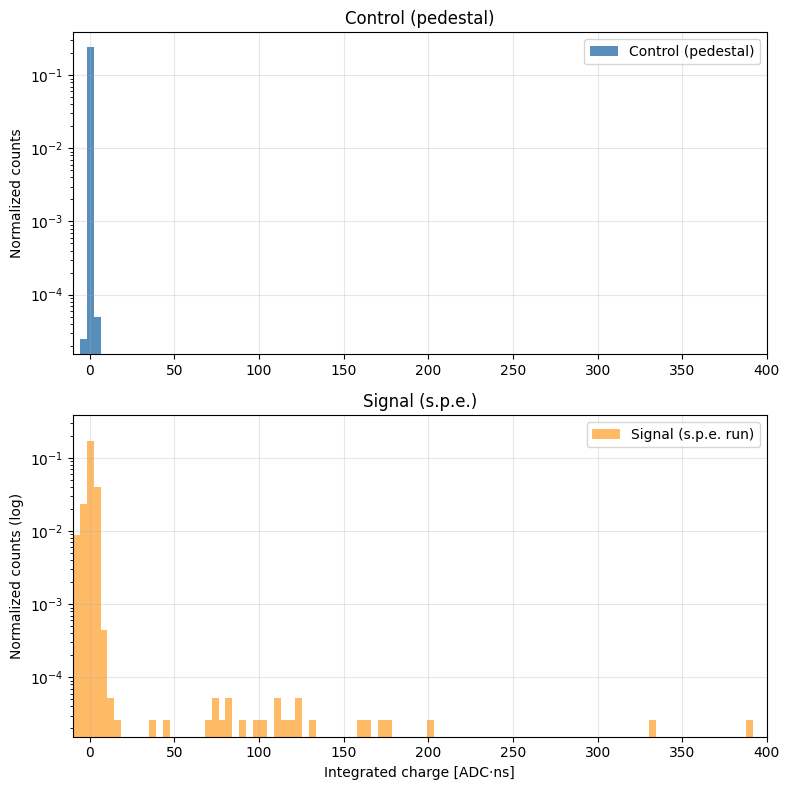

In [ ]:
plot_control_vs_signal(charges_control, charges_signal, bins=100, xlim=(-10,400))

In [ ]:
def plot_with_fits(charges_control, charges_signal,
                   mu_ped, sigma_ped, mu_spe, sigma_spe,
                   ped_window=None, spe_window=None,
                   bins=100, xlim=(-10, 400)):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # ---- Pedestal (lineal) ----
    counts_c, bins_c, _ = ax1.hist(
        charges_control, bins=bins, alpha=0.7,
        label="Control (pedestal)", color="steelblue", range=xlim
    )
    bin_width_c = bins_c[1] - bins_c[0]
    x_c = np.linspace(xlim[0], xlim[1], 400)
    y_c = len(charges_control) * bin_width_c * norm.pdf(x_c, mu_ped, sigma_ped)
    ax1.plot(x_c, y_c, "b-", lw=2,
             label=f"Gaussian fit (μ={mu_ped:.1f}, σ={sigma_ped:.1f})")
    if ped_window is not None:
        ax1.axvline(ped_window[0], color="k", ls="--", lw=1)
        ax1.axvline(ped_window[1], color="k", ls="--", lw=1)
    ax1.set_ylabel("Counts")
    ax1.set_title("Pedestal distribution (linear)")
    ax1.legend()
    ax1.grid(alpha=0.3)

    # ---- Signal (log) ----
    counts_s, bins_s, _ = ax2.hist(
        charges_signal, bins=bins, alpha=0.7,
        label="Signal (s.p.e. run)", color="orange", range=xlim
    )
    bin_width_s = bins_s[1] - bins_s[0]
    x_s = np.linspace(xlim[0], xlim[1], 400)
    y_s = len(charges_signal) * bin_width_s * norm.pdf(x_s, mu_spe, sigma_spe)
    ax2.plot(x_s, y_s, "r-", lw=2,
             label=f"Gaussian fit (μ={mu_spe:.1f}, σ={sigma_spe:.1f})")
    if spe_window is not None:
        ax2.axvline(spe_window[0], color="k", ls="--", lw=1)
        ax2.axvline(spe_window[1], color="k", ls="--", lw=1)
    ax2.set_yscale("log")
    ax2.set_xlabel("Integrated charge [ADC·ns]")
    ax2.set_ylabel("Counts (log)")
    ax2.set_title("s.p.e. distribution (log scale)")
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

Control (pedestal) fit:
  Mode estimate        : 0.011 ADC·ns
  Fit window           : [-0.016, 19.984] ADC·ns  (n=7779)
  Gaussian MLE (μ, σ)  : (0.495 ± 0.005, 0.449)  success=True

Signal (s.p.e.) fit:
  Mode estimate        : 83.889 ADC·ns
  Fit window           : [83.889, 103.889] ADC·ns  (n=2)
  Gaussian MLE (μ, σ)  : (nan ± nan, nan)  success=False

Gain (μ_spe − μ_ped)  : nan ± nan  [ADC·ns]


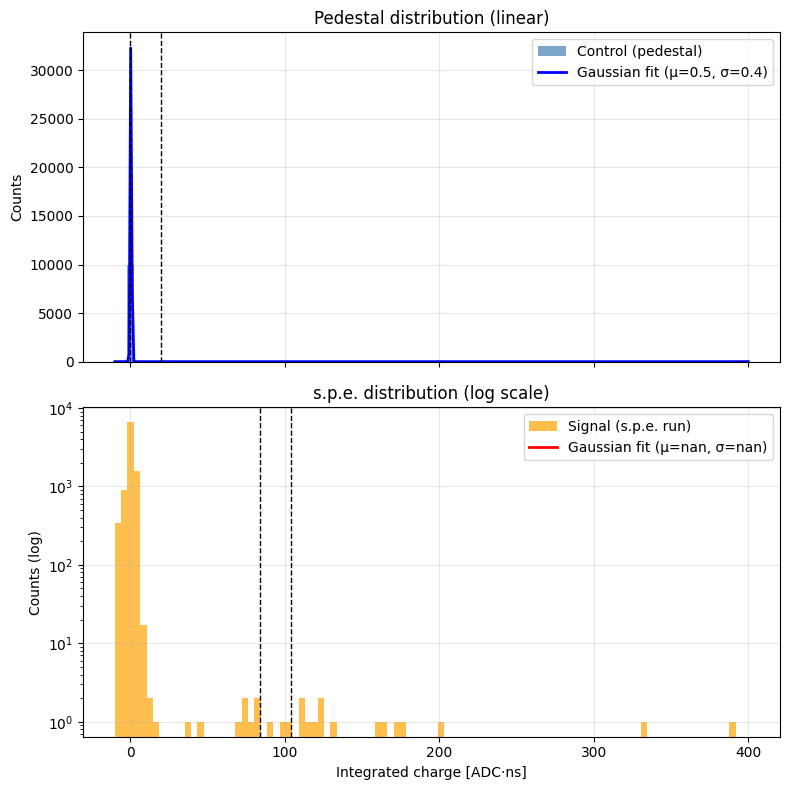

In [ ]:
# --- Pedestal (control) ---
ped_mode, ped_lo, ped_hi, ped_sel = find_modal_window(
    charges_control,
    adc_range=(-50, 50),
)
mu_ped, sigma_ped, ok_ped = fit_gaussian_unbinned(ped_sel)
err_mu_ped = sigma_ped / np.sqrt(len(ped_sel))

print("Control (pedestal) fit:")
print(f"  Mode estimate        : {ped_mode:.3f} ADC·ns")
print(f"  Fit window           : [{ped_lo:.3f}, {ped_hi:.3f}] ADC·ns  (n={len(ped_sel)})")
print(f"  Gaussian MLE (μ, σ)  : ({mu_ped:.3f} ± {err_mu_ped:.3f}, {sigma_ped:.3f})  success={ok_ped}")

# --- s.p.e. (signal) ---
spe_mode, spe_lo, spe_hi, spe_sel = find_modal_window(
    charges_signal,
    adc_range=(80, 220),
)
mu_spe, sigma_spe, ok_spe = fit_gaussian_unbinned(spe_sel)
err_mu_spe = sigma_spe / np.sqrt(len(spe_sel))

print("\nSignal (s.p.e.) fit:")
print(f"  Mode estimate        : {spe_mode:.3f} ADC·ns")
print(f"  Fit window           : [{spe_lo:.3f}, {spe_hi:.3f}] ADC·ns  (n={len(spe_sel)})")
print(f"  Gaussian MLE (μ, σ)  : ({mu_spe:.3f} ± {err_mu_spe:.3f}, {sigma_spe:.3f})  success={ok_spe}")

# --- Gain y su error ---
gain = mu_spe - mu_ped
err_gain = np.sqrt(err_mu_spe**2 + err_mu_ped**2)
print(f"\nGain (μ_spe − μ_ped)  : {gain:.3f} ± {err_gain:.3f}  [ADC·ns]")

# --- Plot conjunto ---
plot_with_fits(
    charges_control=charges_control,
    charges_signal=charges_signal,
    mu_ped=mu_ped,
    sigma_ped=sigma_ped,
    mu_spe=mu_spe,
    sigma_spe=sigma_spe,
    ped_window=(ped_lo, ped_hi),
    spe_window=(spe_lo, spe_hi),
    bins=100,
    xlim=(-10, 400)
)

### Estadísticamente los cálculos son correctos! PERO falta tener en cuenta systematic errors!!!!

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def plot_diagnosis(data, mu, sigma, title="", bins=80, zoom_nsigma=5):
    data = np.asarray(data)
    
    lo = mu - zoom_nsigma * sigma   #centramos el análisis alrededor del peak, donde es más importante!
    hi = mu + zoom_nsigma * sigma
    x = np.linspace(lo, hi, 400)

    bin_width = (hi - lo) / bins
    pdf_counts = norm.pdf(x, loc=mu, scale=sigma) * len(data) * bin_width

    fig, axes = plt.subplots(1,2, figsize=(12,4), sharey=False)

    # linear
    axes[0].hist(data, bins=bins, range=(lo,hi), alpha=0.6, label="Datos (zoom)")
    axes[0].plot(x, pdf_counts, 'r-', lw=2, label=f'Gauss μ={mu:.3f}, σ={sigma:.3f}')
    axes[0].set_title(title + " (lineal)")
    axes[0].set_xlabel("Carga integrada [ADC·ns]")
    axes[0].set_ylabel("Cuentas")
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # log y
    axes[1].hist(data, bins=bins, range=(lo,hi), alpha=0.6, label="Datos (zoom)")
    axes[1].plot(x, pdf_counts, 'r-', lw=2, label=f'Gauss μ={mu:.3f}, σ={sigma:.3f}')
    axes[1].set_yscale('log')
    axes[1].set_title(title + " (log y)")
    axes[1].set_xlabel("Carga integrada [ADC·ns]")
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

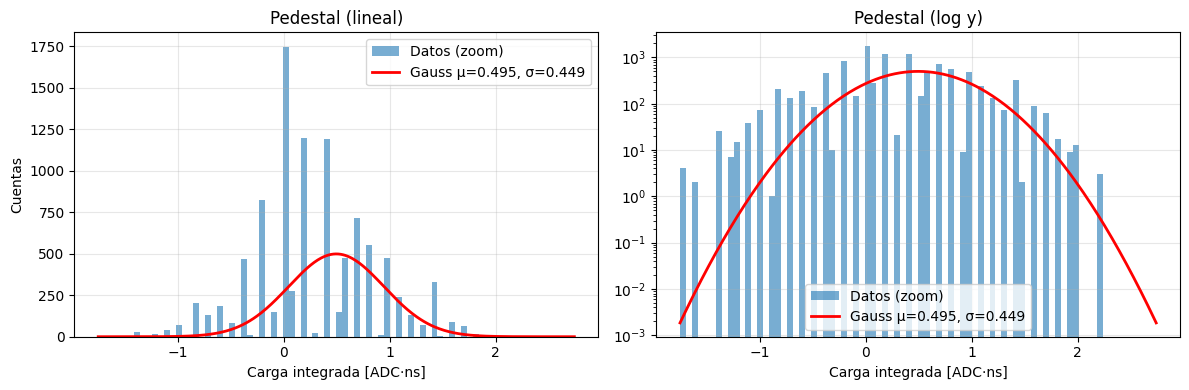

ValueError: supplied range of [nan, nan] is not finite

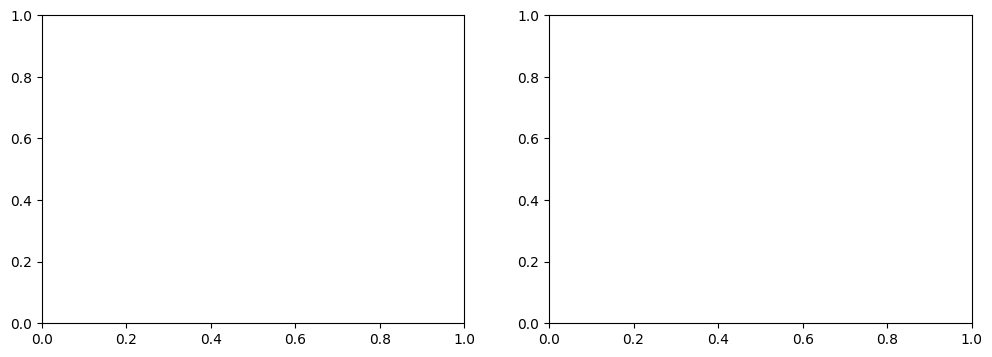

In [ ]:
plot_diagnosis(charges_control, mu_ped, sigma_ped, title="Pedestal")
plot_diagnosis(charges_signal, mu_spe, sigma_spe, title="SPE")